# Import Required Libraries

Only run if on Colab, upload THB_Dataset.zip

In [4]:
from google.colab import files
uploaded = files.upload()

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch import tensor
import numpy as np
import torchvision
from torchvision import datasets,transforms,models
from torch.utils.data import DataLoader
from torch.autograd import Variable
from torch.optim import Adam, lr_scheduler
import matplotlib.pyplot as plt
import time
import os
import copy
import random
import shutil
import glob
!pip install torchmetrics
import torchmetrics
!pip install patool
import patoolib
import pathlib
from torchmetrics.classification import Accuracy, Precision, Recall, F1Score
from sklearn.model_selection import StratifiedKFold
import subprocess

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Function Definitions

In [7]:
def train_model(model, criterion, optimizer, scheduler,  dataloaders, dataset_sizes, num_epochs=15):
    since = time.time()
    torch.cuda.reset_peak_memory_stats(device)
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    # create a list to store the training and validation accuracy values
    train_acc_list = []
    val_acc_list = []

    # create a list to store the training and validation loss values
    train_loss_list = []
    val_loss_list = []

    # initialize metric
    metric = torchmetrics.classification.Accuracy(task="multiclass", num_classes=3)
    predicted_labels = []
    ground_truth_labels = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs-1}')
        print('-'*10)

        #Training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            #Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                #forward
                #track history only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    #_,preds = torch.max(outputs,1)
                    #loss = criterion(outputs,labels)
                    #googlenetcprfix
                    if str(type(outputs)) == "<class 'torch.Tensor'>":
                        _,preds = torch.max(outputs,1)
                        loss = criterion(outputs,labels)
                    else :
                        _,preds = torch.max(outputs.logits,1)
                        loss = criterion(outputs.logits,labels)

                    #backward + optimize only in train
                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                #statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if phase == 'train':
                train_acc_list.append(epoch_acc.item())
                train_loss_list.append(epoch_loss)
            elif phase == 'val':
                val_acc_list.append(epoch_acc.item())
                val_loss_list.append(epoch_loss)

            predicted_labels.append(preds.cpu())
            ground_truth_labels.append(labels.cpu())


            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            #deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()


    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    #calculate accuracy
    predicted_labels = torch.cat(predicted_labels)
    ground_truth_labels = torch.cat(ground_truth_labels)
    accuracy = Accuracy(task="multiclass", num_classes=3)
    accuracy(predicted_labels, ground_truth_labels)
    print(f'Accuracy: {accuracy.compute():.4f}')

    #calculate precision
    precision = Precision(task="multiclass", average='macro', num_classes=3)
    precision(predicted_labels, ground_truth_labels)
    print(f'Precision: {precision.compute():.4f}')

    #calculate recall
    recall = Recall(task="multiclass", average='macro', num_classes=3)
    recall(predicted_labels, ground_truth_labels)
    print(f'Recall: {recall.compute():.4f}')

    #calculate f1 score
    f1 = F1Score(task="multiclass", average='macro', num_classes=3)
    f1(predicted_labels, ground_truth_labels)
    print(f'F1: {f1.compute():.4f}')

    #calculate confusion matrix
    cm = torchmetrics.functional.confusion_matrix(predicted_labels, ground_truth_labels, num_classes=3, task="multiclass")
    print(f'Confusion Matrix: \n{cm}')

    #plot the training and validation accuracy
    plt.figure(figsize=(10, 6))

    plt.plot(train_acc_list, label='Training Accuracy')
    plt.plot(val_acc_list, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.grid(True)

    plt.show()

    #plot the training and validation loss

    plt.figure(figsize=(10, 6))

    plt.plot(train_loss_list, label='Training Loss')
    plt.plot(val_loss_list, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)

    plt.show()

    metrics = {}
    metrics['accuracy'] = accuracy.compute()
    metrics['precision'] = precision.compute()
    metrics['recall'] = recall.compute()
    metrics['f1'] = f1.compute()
    metrics['time'] = time_elapsed
    metrics['memory'] = torch.cuda.max_memory_allocated()/(1024*1024)


    #load best model weights
    model.load_state_dict(best_model_wts)
    return model, metrics


def print_metrics(metrics):
  #total_time = metrics["time"]*5
  print(f'Average accuracy: {metrics["accuracy"]:.4f}')
  print(f'Average precision: {metrics["precision"]:.4f}')
  print(f'Average recall: {metrics["recall"]:.4f}')
  print(f'Average F1 score: {metrics["f1"]:.4f}')
  print(f'Average Time elapsed: {metrics["time"]:.4f} seconds')
  print(f'Memory Usage: {metrics["memory"]:.4f} MiB')


def get_transforms(model_name):

  # resize_transform = transforms.Resize(224, interpolation=InterpolationMode.BILINEAR)
  # resize_transform = transforms.Resize(224, interpolation=InterpolationMode.BICUBIC)
  # resize_transform = transforms.Resize(224, interpolation=InterpolationMode.NEAREST)

  mean = np.array([0.485,0.456,0.406])
  std = np.array([0.229,0.224,0.225])
  if model_name in ['googlenet', 'resnet18', 'alexnet']:
      data_transforms = {
          'train':transforms.Compose([
              transforms.RandomResizedCrop(224),
              transforms.RandomHorizontalFlip(),
              transforms.ToTensor(),
              transforms.Normalize(mean,std)
          ]),
          'val':transforms.Compose([
              transforms.Resize(256),
              transforms.CenterCrop(224),
              transforms.ToTensor(),
              transforms.Normalize(mean,std)
          ])
      }
  elif model_name == 'inceptionv3':
      data_transforms = {
          'train':transforms.Compose([
              transforms.Resize((299, 299)),
              transforms.RandomHorizontalFlip(),
              transforms.ToTensor(),
              transforms.Normalize(mean,std)
          ]),
          'val':transforms.Compose([
              transforms.Resize((299, 299)),
              transforms.ToTensor(),
              transforms.Normalize(mean,std)
          ])
      }
  elif model_name == 'vgg16':
      data_transforms = {
          'train':transforms.Compose([
              transforms.Resize(224),
              transforms.CenterCrop(224),
              transforms.RandomHorizontalFlip(),
              transforms.ToTensor(),
              transforms.Normalize(mean,std)
          ]),
          'val':transforms.Compose([
              transforms.Resize(224),
              transforms.CenterCrop(224),
              transforms.ToTensor(),
              transforms.Normalize(mean,std)
          ])
      }
  else:
    data_transforms = {
        'train':transforms.Compose([
            transforms.Resize((30, 30)),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)  # Normalize all three channels
        ]),
        'val':transforms.Compose([
            transforms.Resize((30, 30)),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)  # Normalize all three channels
        ])
    }
  return data_transforms

#returns pretrained model trained on ImageNet dataset
def get_pretrained_model(model_name, pretrained, device='cpu', weights=None):
  if pretrained == True:
      if model_name == 'googlenet':
          return models.googlenet(pretrained=True)
      elif model_name == 'inceptionv3':
          return models.inception_v3(pretrained=True)
      elif model_name == 'vgg16':
          return models.vgg16(pretrained=True)
      elif model_name == 'resnet18':
          return models.resnet18(pretrained=True)
      elif model_name == 'alexnet':
          return models.alexnet(pretrained=True)
      else:
          #load voltavision here.
          raise ValueError(f"Invalid model_name: {model_name}")
  else:
    if model_name == 'googlenet':
        return models.googlenet(weights=weights).to(device)
    elif model_name == 'inceptionv3':
        return models.inception_v3(weights=weights).to(device)
    elif model_name == 'vgg16':
        return models.vgg16(weights=weights).to(device)
    elif model_name == 'resnet18':
        return models.resnet18(weights=weights).to(device)
    elif model_name == 'alexnet':
        return models.alexnet(weights=weights).to(device)
    else:
        raise ValueError(f"Invalid model_name: {model_name}")



In [8]:

def preTrainImageNet(model_name, classes):
  data_transforms = get_transforms(model_name)
  # Get a list of all image filenames and corresponding labels
  all_filenames = []
  all_labels = []
  # Iterate through each class folder and associate each image with corresponding lable
  for class_name in classes:
      class_folder = os.path.join(folder_path, class_name)
      class_filenames = [os.path.join(class_folder, filename) for filename in os.listdir(class_folder)]

      # Extend the list of all_filenames and all_labels
      all_filenames.extend(class_filenames)
      all_labels.extend([class_name] * len(class_filenames))

  # Use StratifiedKFold for creating folds
  num_folds = 5
  stratified_kfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

  all_metrics = []

  # Perform stratified k-fold cross-validation
  for i, (train_idx, test_idx) in enumerate(stratified_kfold.split(all_filenames, all_labels)):
    train_FileNames = [all_filenames[idx] for idx in train_idx]
    val_FileNames = [all_filenames[idx] for idx in test_idx]
    print('Fold: ',i)
    print('Training: ', len(train_FileNames))
    print('Validation: ', len(val_FileNames))
    fold_dir = f'./splitted_dataset/fold{i}'
    if not os.path.exists(fold_dir):
        os.makedirs(fold_dir+'/train')
        os.makedirs(fold_dir+'/val')

        # Creating the class folders in train and validation folders
        for class_name in classes:
            os.makedirs(fold_dir+'/train/' + class_name)
            os.makedirs(fold_dir+'/val/' + class_name)

    for name in train_FileNames:
        class_name = name.split('/')[1]
        shutil.copy(name, fold_dir+'/train/' + class_name)
    for name in val_FileNames:
        class_name = name.split('/')[1]
        shutil.copy(name, fold_dir+'/val/' + class_name)


    sets = ['train','val']
    image_datasets = {x:datasets.ImageFolder(os.path.join(fold_dir,x),
                                            data_transforms[x])
                    for x in ['train','val']}
    dataloaders = {x:torch.utils.data.DataLoader(image_datasets[x],batch_size=4,
                                                shuffle=True,num_workers=0)
                    for x in ['train','val']}

    dataset_sizes = {x:len(image_datasets[x]) for x in ['train','val']}


    pretrained_model_ImageNet = get_pretrained_model(model_name, True)

    #freezing previous layers
    for param in pretrained_model_ImageNet.parameters():
        param.requires_grad = False

    #exchange the last layer
    num_classes = 3

    if model_name in ['googlenet', 'resnet18']:
        pretrained_model_ImageNet.fc = nn.Linear(in_features=pretrained_model_ImageNet.fc.in_features, out_features=num_classes, device=device)
    elif model_name in ['alexnet', 'vgg16']:
        num_ftrs = pretrained_model_ImageNet.classifier[6].in_features
        pretrained_model_ImageNet.classifier[6] = nn.Linear(num_ftrs, 3)
    elif model_name == 'inceptionv3':
        num_ftrs = pretrained_model_ImageNet.fc.in_features
        pretrained_model_ImageNet.fc = nn.Linear(num_ftrs, 3)
    else:
        #use voltavision here.
        raise ValueError(f"Invalid model_name: {model_name}")

    pretrained_model_ImageNet.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(pretrained_model_ImageNet.parameters(),lr=0.001)

    #scheduler
    step_lr_scheduler = lr_scheduler.StepLR(optimizer,step_size=7,gamma=0.1)

    model_ft, metrics = train_model(pretrained_model_ImageNet, criterion, optimizer, step_lr_scheduler, dataloaders, dataset_sizes, num_epochs=25)

    all_metrics.append(metrics)

  avg_metrics = {key: np.mean([m[key] for m in all_metrics]) for key in all_metrics[0]}
  print_metrics(avg_metrics)

# Fine-Tuning using the THB dataset

In [9]:
if not os.path.exists('./THB_dataset'):
    patoolib.extract_archive('THB_dataset.zip')


INFO patool: Extracting THB_dataset.zip ...
INFO:patool:Extracting THB_dataset.zip ...
INFO patool: running /usr/bin/7z x -o./Unpack_jkbdle8j -- THB_dataset.zip
INFO:patool:running /usr/bin/7z x -o./Unpack_jkbdle8j -- THB_dataset.zip
INFO patool:     with input=''
INFO:patool:    with input=''
INFO patool: ... THB_dataset.zip extracted to `THB_dataset'.
INFO:patool:... THB_dataset.zip extracted to `THB_dataset'.


In [10]:
folder_path = 'THB_dataset'
classes = os.listdir(folder_path)
print(classes)

['Transistor', 'Bluetooth', 'Humidity']


`['googlenet','inceptionv3','vgg16','resnet18','alexnet']`

# GoogLeNet




```
Average accuracy: 0.7800
Average precision: 0.7865
Average recall: 0.7829
Average F1 score: 0.7794
Average Time elapsed: 84.1102 seconds
Memory Usage: 225.0852 MiB
```



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Fold:  0
Training:  262
Validation:  66


Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 55.4MB/s]


Epoch 0/24
----------
train Loss: 1.0959 Acc: 0.3626
val Loss: 1.0010 Acc: 0.6061

Epoch 1/24
----------
train Loss: 1.0086 Acc: 0.5382
val Loss: 0.9180 Acc: 0.7727

Epoch 2/24
----------
train Loss: 0.9665 Acc: 0.6107
val Loss: 0.8443 Acc: 0.8636

Epoch 3/24
----------
train Loss: 0.9315 Acc: 0.6489
val Loss: 0.7795 Acc: 0.8939

Epoch 4/24
----------
train Loss: 0.8924 Acc: 0.7061
val Loss: 0.7326 Acc: 0.8636

Epoch 5/24
----------
train Loss: 0.8267 Acc: 0.7443
val Loss: 0.6911 Acc: 0.9545

Epoch 6/24
----------
train Loss: 0.7819 Acc: 0.7977
val Loss: 0.6456 Acc: 0.9242

Epoch 7/24
----------
train Loss: 0.8060 Acc: 0.7710
val Loss: 0.6474 Acc: 0.9697

Epoch 8/24
----------
train Loss: 0.7651 Acc: 0.7824
val Loss: 0.6206 Acc: 0.9242

Epoch 9/24
----------
train Loss: 0.7589 Acc: 0.8168
val Loss: 0.6234 Acc: 0.9394

Epoch 10/24
----------
train Loss: 0.7706 Acc: 0.8206
val Loss: 0.6252 Acc: 0.9242

Epoch 11/24
----------
train Loss: 0.7618 Acc: 0.8206
val Loss: 0.6257 Acc: 0.9545

Ep

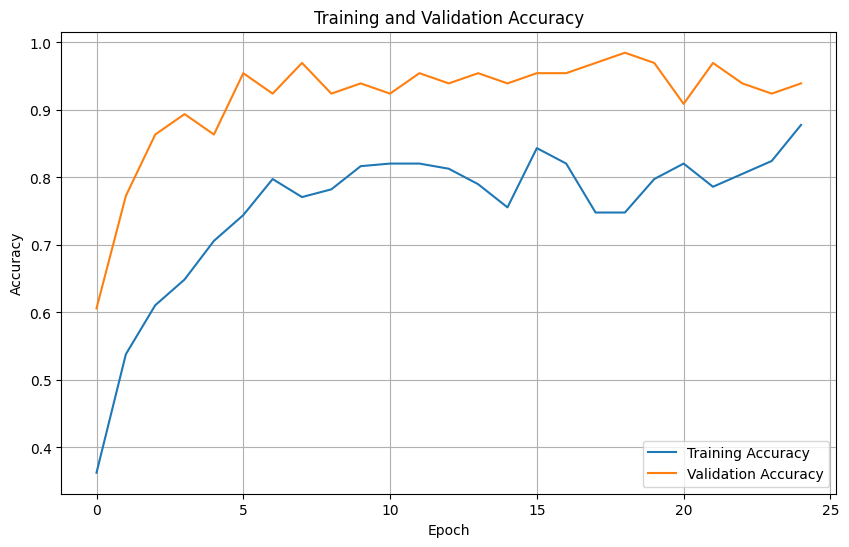

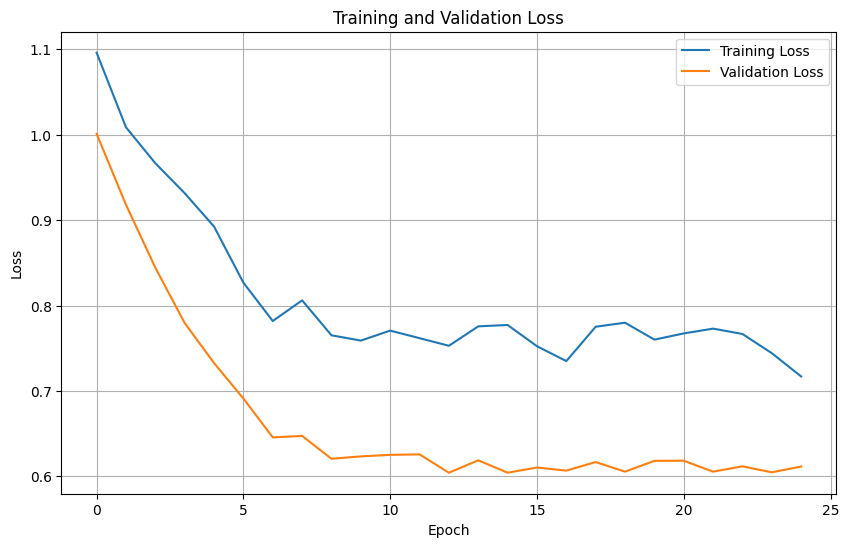

Fold:  1
Training:  262
Validation:  66
Epoch 0/24
----------
train Loss: 1.0979 Acc: 0.3359
val Loss: 1.0767 Acc: 0.3939

Epoch 1/24
----------
train Loss: 1.0256 Acc: 0.5420
val Loss: 0.9610 Acc: 0.7121

Epoch 2/24
----------
train Loss: 0.9442 Acc: 0.6336
val Loss: 0.9052 Acc: 0.8182

Epoch 3/24
----------
train Loss: 0.9175 Acc: 0.6603
val Loss: 0.8300 Acc: 0.8788

Epoch 4/24
----------
train Loss: 0.8803 Acc: 0.7061
val Loss: 0.7634 Acc: 0.9091

Epoch 5/24
----------
train Loss: 0.8538 Acc: 0.7366
val Loss: 0.7196 Acc: 0.9242

Epoch 6/24
----------
train Loss: 0.8544 Acc: 0.7405
val Loss: 0.6854 Acc: 0.9394

Epoch 7/24
----------
train Loss: 0.7778 Acc: 0.8168
val Loss: 0.6777 Acc: 0.9545

Epoch 8/24
----------
train Loss: 0.7633 Acc: 0.8397
val Loss: 0.6817 Acc: 0.9545

Epoch 9/24
----------
train Loss: 0.7699 Acc: 0.7977
val Loss: 0.6713 Acc: 0.9394

Epoch 10/24
----------
train Loss: 0.7668 Acc: 0.8359
val Loss: 0.6742 Acc: 0.9242

Epoch 11/24
----------
train Loss: 0.7798 Acc:

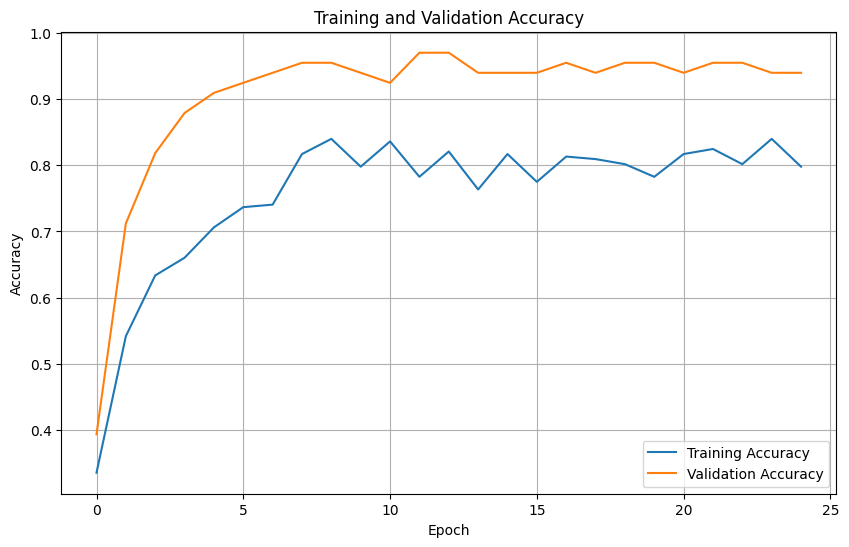

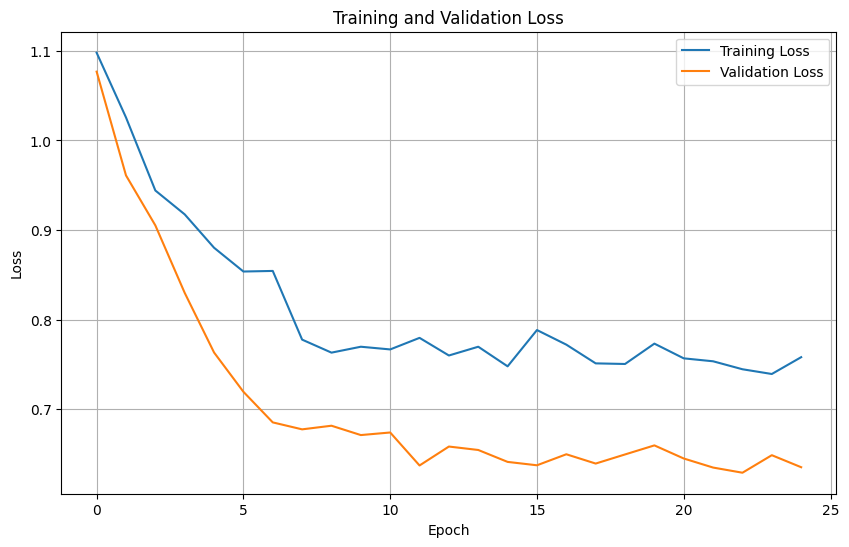

Fold:  2
Training:  262
Validation:  66
Epoch 0/24
----------
train Loss: 1.0854 Acc: 0.4198
val Loss: 1.0150 Acc: 0.4545

Epoch 1/24
----------
train Loss: 1.0172 Acc: 0.5267
val Loss: 0.9283 Acc: 0.7273

Epoch 2/24
----------
train Loss: 0.9641 Acc: 0.6107
val Loss: 0.8455 Acc: 0.8333

Epoch 3/24
----------
train Loss: 0.9354 Acc: 0.6107
val Loss: 0.7812 Acc: 0.8788

Epoch 4/24
----------
train Loss: 0.8552 Acc: 0.7634
val Loss: 0.7158 Acc: 0.8939

Epoch 5/24
----------
train Loss: 0.8589 Acc: 0.7214
val Loss: 0.6870 Acc: 0.8333

Epoch 6/24
----------
train Loss: 0.8167 Acc: 0.7710
val Loss: 0.6264 Acc: 0.9394

Epoch 7/24
----------
train Loss: 0.8202 Acc: 0.6947
val Loss: 0.6230 Acc: 0.9242

Epoch 8/24
----------
train Loss: 0.7776 Acc: 0.7824
val Loss: 0.6180 Acc: 0.9545

Epoch 9/24
----------
train Loss: 0.7733 Acc: 0.7939
val Loss: 0.6221 Acc: 0.9697

Epoch 10/24
----------
train Loss: 0.7923 Acc: 0.7634
val Loss: 0.6073 Acc: 0.9545

Epoch 11/24
----------
train Loss: 0.7818 Acc:

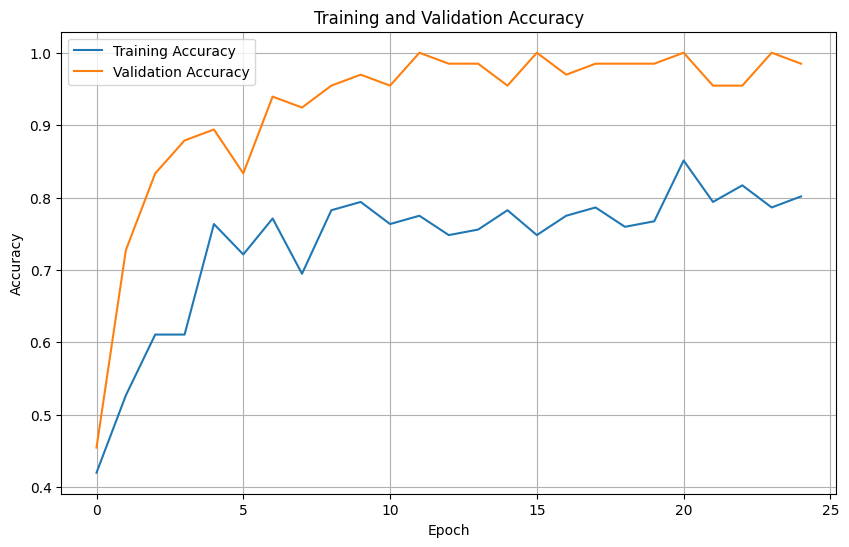

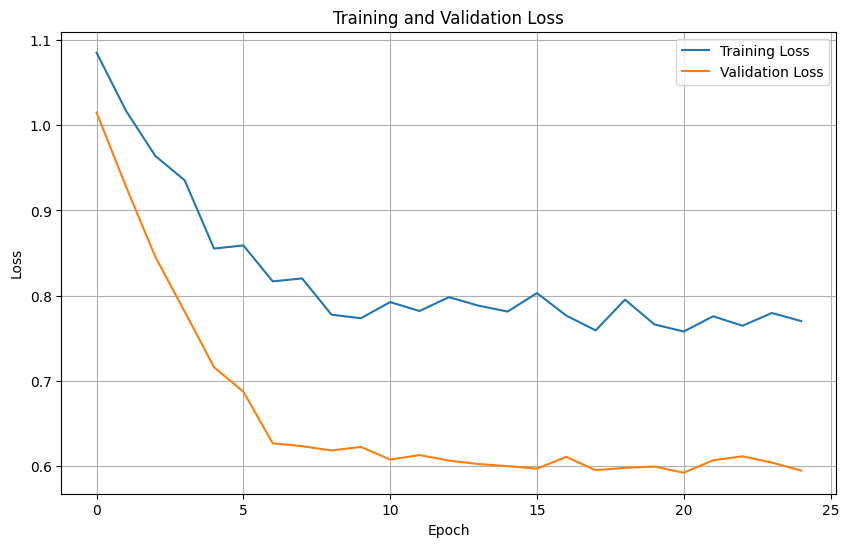

Fold:  3
Training:  263
Validation:  65
Epoch 0/24
----------
train Loss: 1.0540 Acc: 0.4449
val Loss: 0.9665 Acc: 0.7231

Epoch 1/24
----------
train Loss: 0.9800 Acc: 0.6046
val Loss: 0.8741 Acc: 0.7846

Epoch 2/24
----------
train Loss: 0.9391 Acc: 0.6578
val Loss: 0.8172 Acc: 0.8615

Epoch 3/24
----------
train Loss: 0.9100 Acc: 0.6882
val Loss: 0.7471 Acc: 0.9077

Epoch 4/24
----------
train Loss: 0.8848 Acc: 0.6730
val Loss: 0.6966 Acc: 0.9846

Epoch 5/24
----------
train Loss: 0.8142 Acc: 0.7719
val Loss: 0.6620 Acc: 0.9692

Epoch 6/24
----------
train Loss: 0.7819 Acc: 0.7719
val Loss: 0.6131 Acc: 0.9692

Epoch 7/24
----------
train Loss: 0.7815 Acc: 0.7795
val Loss: 0.6109 Acc: 1.0000

Epoch 8/24
----------
train Loss: 0.7709 Acc: 0.7909
val Loss: 0.6099 Acc: 0.9538

Epoch 9/24
----------
train Loss: 0.7631 Acc: 0.8099
val Loss: 0.6190 Acc: 0.9692

Epoch 10/24
----------
train Loss: 0.7725 Acc: 0.7833
val Loss: 0.5996 Acc: 0.9538

Epoch 11/24
----------
train Loss: 0.7707 Acc:

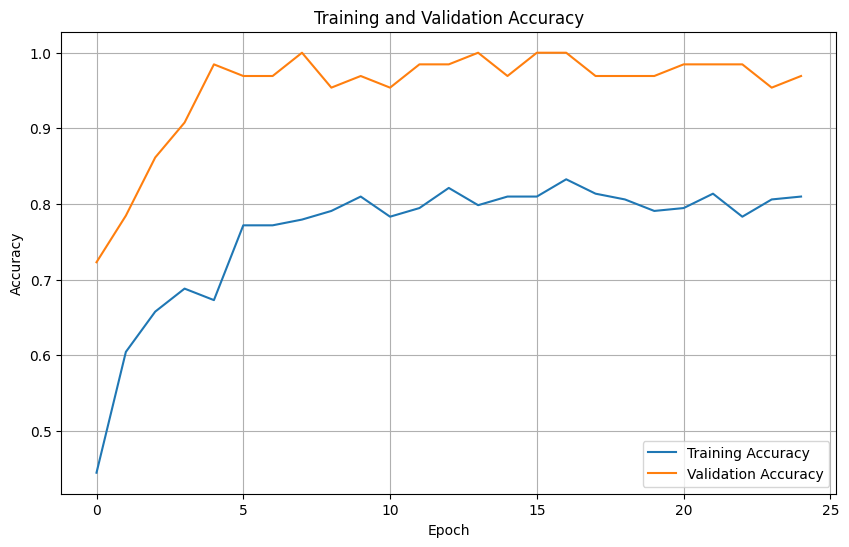

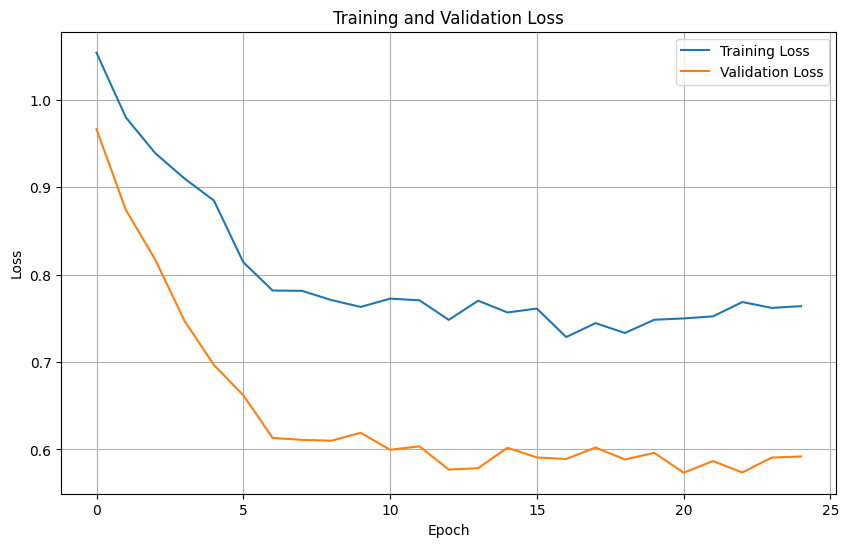

Fold:  4
Training:  263
Validation:  65
Epoch 0/24
----------
train Loss: 1.0980 Acc: 0.3536
val Loss: 0.9936 Acc: 0.6308

Epoch 1/24
----------
train Loss: 1.0358 Acc: 0.4905
val Loss: 0.9056 Acc: 0.8154

Epoch 2/24
----------
train Loss: 0.9722 Acc: 0.6388
val Loss: 0.8420 Acc: 0.9231

Epoch 3/24
----------
train Loss: 0.9427 Acc: 0.6388
val Loss: 0.7766 Acc: 0.9385

Epoch 4/24
----------
train Loss: 0.8739 Acc: 0.7338
val Loss: 0.7185 Acc: 0.9692

Epoch 5/24
----------
train Loss: 0.8518 Acc: 0.7338
val Loss: 0.6599 Acc: 0.9692

Epoch 6/24
----------
train Loss: 0.8078 Acc: 0.7833
val Loss: 0.6184 Acc: 0.9692

Epoch 7/24
----------
train Loss: 0.7757 Acc: 0.8175
val Loss: 0.6284 Acc: 0.9692

Epoch 8/24
----------
train Loss: 0.8175 Acc: 0.7452
val Loss: 0.6302 Acc: 0.9846

Epoch 9/24
----------
train Loss: 0.8090 Acc: 0.7567
val Loss: 0.6160 Acc: 0.9846

Epoch 10/24
----------
train Loss: 0.7606 Acc: 0.7909
val Loss: 0.6166 Acc: 0.9538

Epoch 11/24
----------
train Loss: 0.7975 Acc:

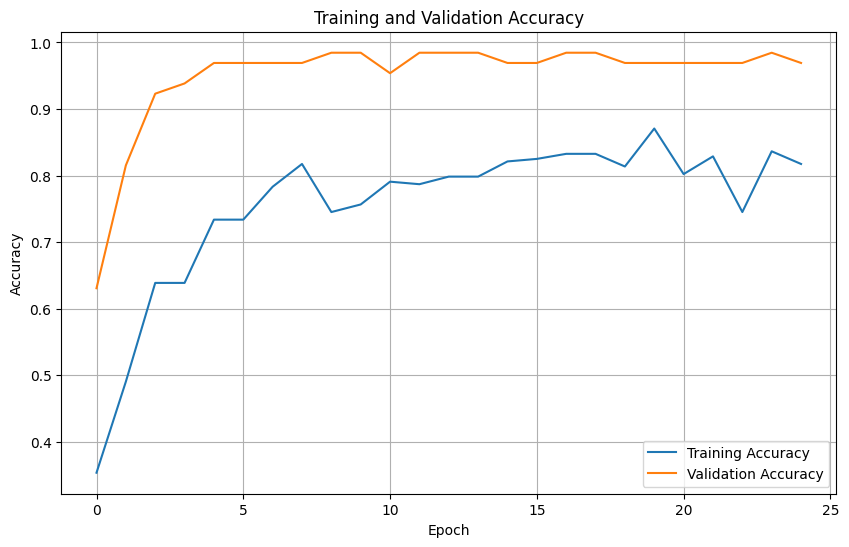

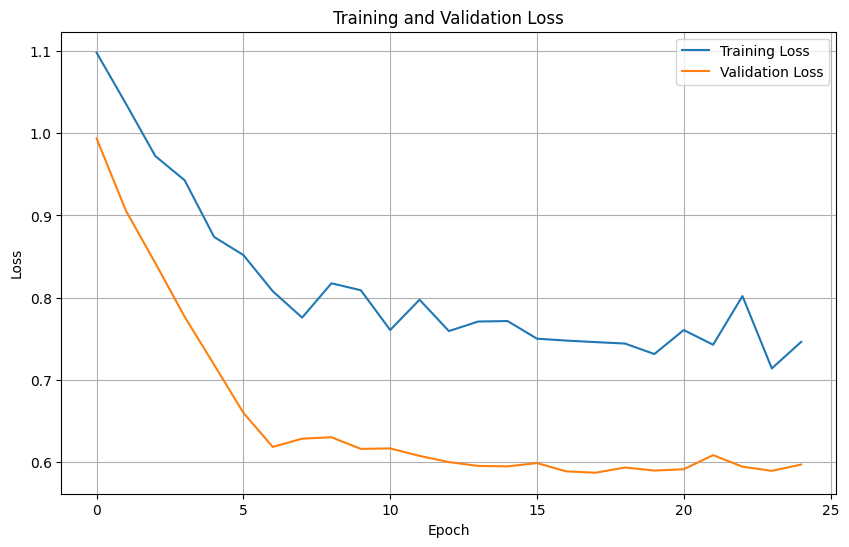

Average accuracy: 0.7800
Average precision: 0.7865
Average recall: 0.7829
Average F1 score: 0.7794
Average Time elapsed: 84.1102 seconds
Memory Usage: 225.0852 MiB


In [11]:
preTrainImageNet("googlenet",classes)

# AlexNet




```
Average accuracy: 0.9640
Average precision: 0.9638
Average recall: 0.9635
Average F1 score: 0.9632
Average Time elapsed: 66.8584 seconds
Memory Usage: 844.8316 MiB
```



Fold:  0
Training:  262
Validation:  66


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 127MB/s]


Epoch 0/24
----------
train Loss: 0.5137 Acc: 0.7901
val Loss: 0.1662 Acc: 0.9697

Epoch 1/24
----------
train Loss: 0.2196 Acc: 0.9389
val Loss: 0.0835 Acc: 0.9848

Epoch 2/24
----------
train Loss: 0.1949 Acc: 0.9427
val Loss: 0.0805 Acc: 0.9848

Epoch 3/24
----------
train Loss: 0.1300 Acc: 0.9656
val Loss: 0.0751 Acc: 0.9848

Epoch 4/24
----------
train Loss: 0.1532 Acc: 0.9427
val Loss: 0.0485 Acc: 0.9848

Epoch 5/24
----------
train Loss: 0.1379 Acc: 0.9504
val Loss: 0.0443 Acc: 0.9848

Epoch 6/24
----------
train Loss: 0.1540 Acc: 0.9389
val Loss: 0.0477 Acc: 0.9848

Epoch 7/24
----------
train Loss: 0.1078 Acc: 0.9618
val Loss: 0.0442 Acc: 0.9848

Epoch 8/24
----------
train Loss: 0.1646 Acc: 0.9466
val Loss: 0.0409 Acc: 0.9848

Epoch 9/24
----------
train Loss: 0.1106 Acc: 0.9695
val Loss: 0.0407 Acc: 0.9848

Epoch 10/24
----------
train Loss: 0.1067 Acc: 0.9618
val Loss: 0.0397 Acc: 0.9848

Epoch 11/24
----------
train Loss: 0.0911 Acc: 0.9771
val Loss: 0.0404 Acc: 0.9848

Ep

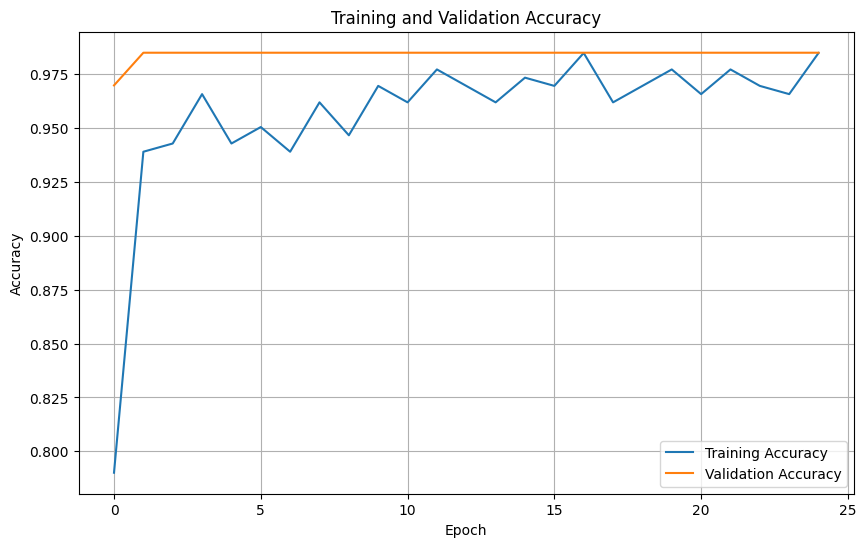

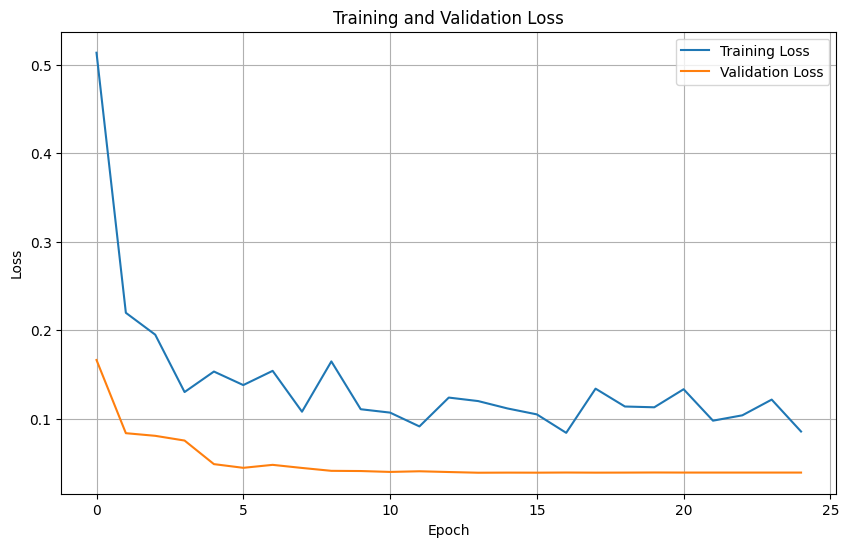

Fold:  1
Training:  262
Validation:  66
Epoch 0/24
----------
train Loss: 0.4642 Acc: 0.8511
val Loss: 0.1405 Acc: 0.9697

Epoch 1/24
----------
train Loss: 0.2273 Acc: 0.9504
val Loss: 0.0780 Acc: 1.0000

Epoch 2/24
----------
train Loss: 0.1640 Acc: 0.9580
val Loss: 0.0530 Acc: 1.0000

Epoch 3/24
----------
train Loss: 0.2024 Acc: 0.9389
val Loss: 0.0582 Acc: 0.9848

Epoch 4/24
----------
train Loss: 0.1497 Acc: 0.9466
val Loss: 0.0446 Acc: 1.0000

Epoch 5/24
----------
train Loss: 0.1388 Acc: 0.9466
val Loss: 0.0430 Acc: 0.9848

Epoch 6/24
----------
train Loss: 0.1581 Acc: 0.9466
val Loss: 0.0710 Acc: 0.9848

Epoch 7/24
----------
train Loss: 0.1715 Acc: 0.9389
val Loss: 0.0415 Acc: 1.0000

Epoch 8/24
----------
train Loss: 0.0969 Acc: 0.9809
val Loss: 0.0322 Acc: 1.0000

Epoch 9/24
----------
train Loss: 0.0964 Acc: 0.9618
val Loss: 0.0296 Acc: 1.0000

Epoch 10/24
----------
train Loss: 0.1447 Acc: 0.9580
val Loss: 0.0289 Acc: 1.0000

Epoch 11/24
----------
train Loss: 0.1302 Acc:

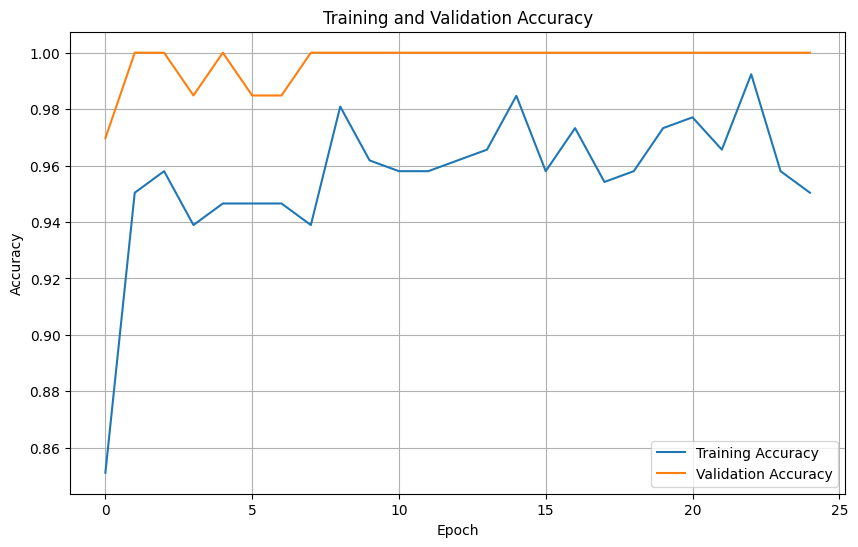

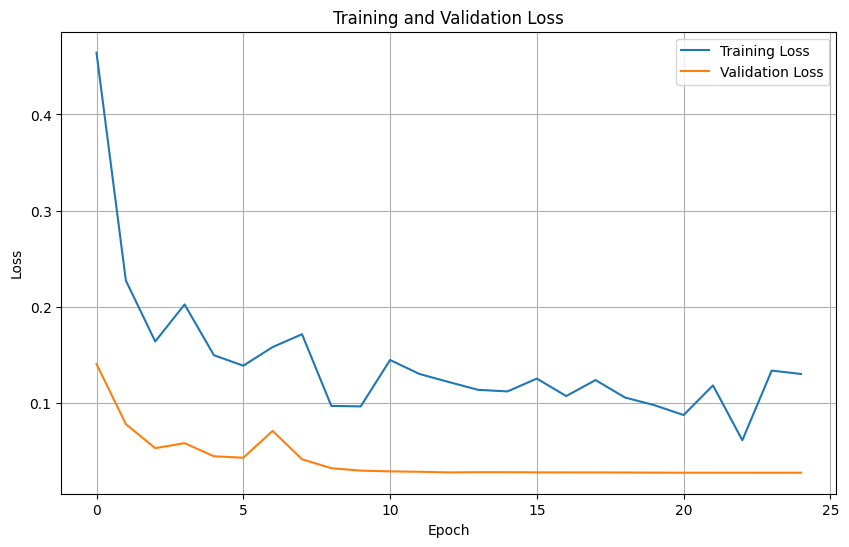

Fold:  2
Training:  262
Validation:  66
Epoch 0/24
----------
train Loss: 0.5266 Acc: 0.7824
val Loss: 0.1366 Acc: 0.9545

Epoch 1/24
----------
train Loss: 0.2270 Acc: 0.9275
val Loss: 0.0747 Acc: 0.9848

Epoch 2/24
----------
train Loss: 0.1634 Acc: 0.9656
val Loss: 0.0523 Acc: 0.9848

Epoch 3/24
----------
train Loss: 0.1809 Acc: 0.9351
val Loss: 0.0612 Acc: 0.9697

Epoch 4/24
----------
train Loss: 0.1170 Acc: 0.9733
val Loss: 0.0498 Acc: 0.9697

Epoch 5/24
----------
train Loss: 0.1486 Acc: 0.9542
val Loss: 0.0487 Acc: 0.9697

Epoch 6/24
----------
train Loss: 0.1163 Acc: 0.9542
val Loss: 0.0431 Acc: 0.9697

Epoch 7/24
----------
train Loss: 0.1157 Acc: 0.9695
val Loss: 0.0423 Acc: 0.9697

Epoch 8/24
----------
train Loss: 0.0854 Acc: 0.9733
val Loss: 0.0418 Acc: 0.9697

Epoch 9/24
----------
train Loss: 0.1352 Acc: 0.9580
val Loss: 0.0415 Acc: 0.9697

Epoch 10/24
----------
train Loss: 0.1094 Acc: 0.9733
val Loss: 0.0398 Acc: 0.9848

Epoch 11/24
----------
train Loss: 0.1037 Acc:

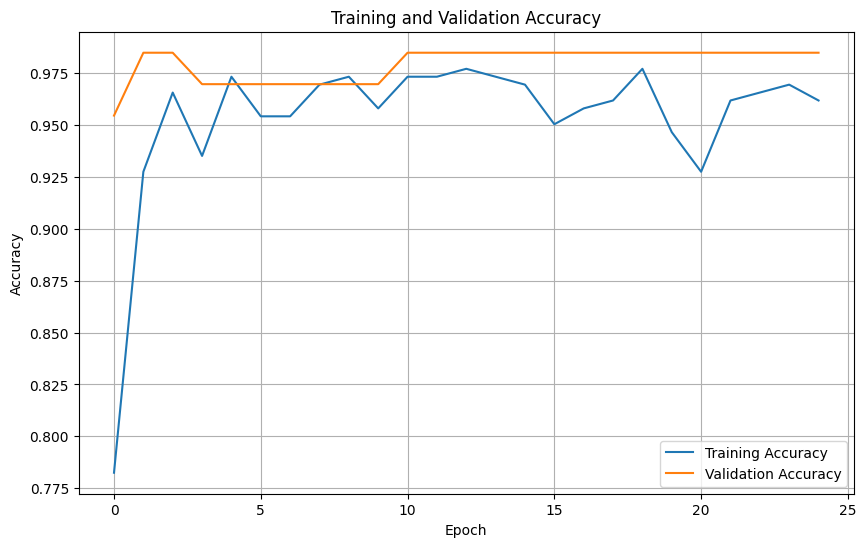

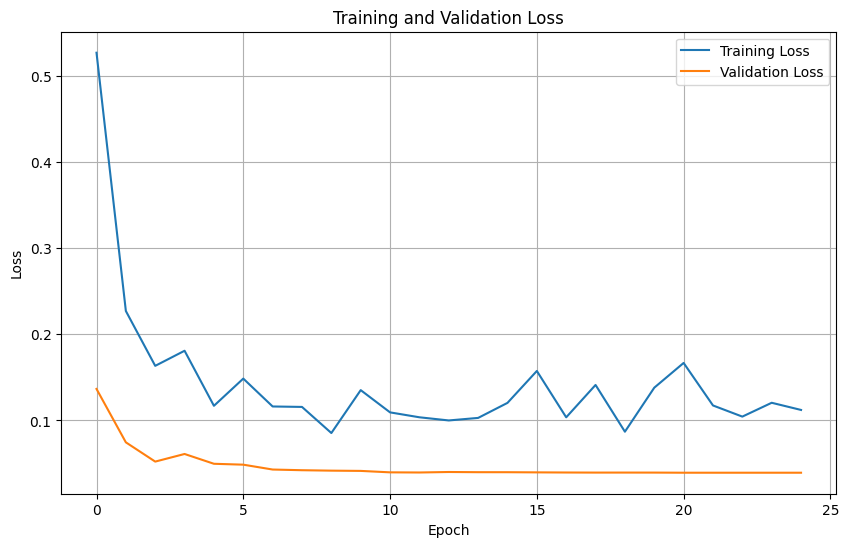

Fold:  3
Training:  263
Validation:  65
Epoch 0/24
----------
train Loss: 0.5114 Acc: 0.8099
val Loss: 0.1248 Acc: 0.9846

Epoch 1/24
----------
train Loss: 0.2369 Acc: 0.9202
val Loss: 0.0632 Acc: 1.0000

Epoch 2/24
----------
train Loss: 0.1902 Acc: 0.9544
val Loss: 0.0796 Acc: 1.0000

Epoch 3/24
----------
train Loss: 0.1542 Acc: 0.9506
val Loss: 0.0443 Acc: 0.9846

Epoch 4/24
----------
train Loss: 0.1507 Acc: 0.9544
val Loss: 0.0304 Acc: 1.0000

Epoch 5/24
----------
train Loss: 0.1220 Acc: 0.9696
val Loss: 0.0273 Acc: 1.0000

Epoch 6/24
----------
train Loss: 0.1303 Acc: 0.9506
val Loss: 0.0243 Acc: 1.0000

Epoch 7/24
----------
train Loss: 0.1231 Acc: 0.9696
val Loss: 0.0242 Acc: 1.0000

Epoch 8/24
----------
train Loss: 0.1261 Acc: 0.9582
val Loss: 0.0248 Acc: 1.0000

Epoch 9/24
----------
train Loss: 0.1034 Acc: 0.9810
val Loss: 0.0239 Acc: 1.0000

Epoch 10/24
----------
train Loss: 0.0961 Acc: 0.9696
val Loss: 0.0240 Acc: 1.0000

Epoch 11/24
----------
train Loss: 0.0984 Acc:

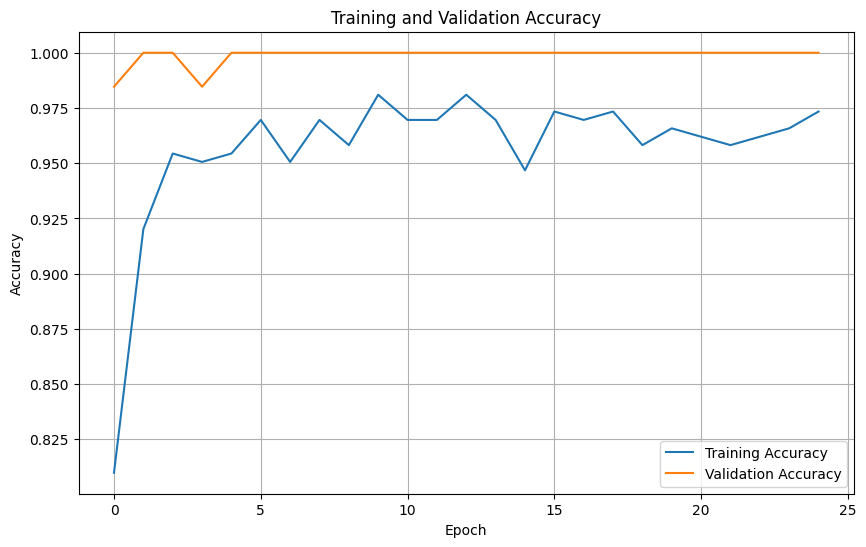

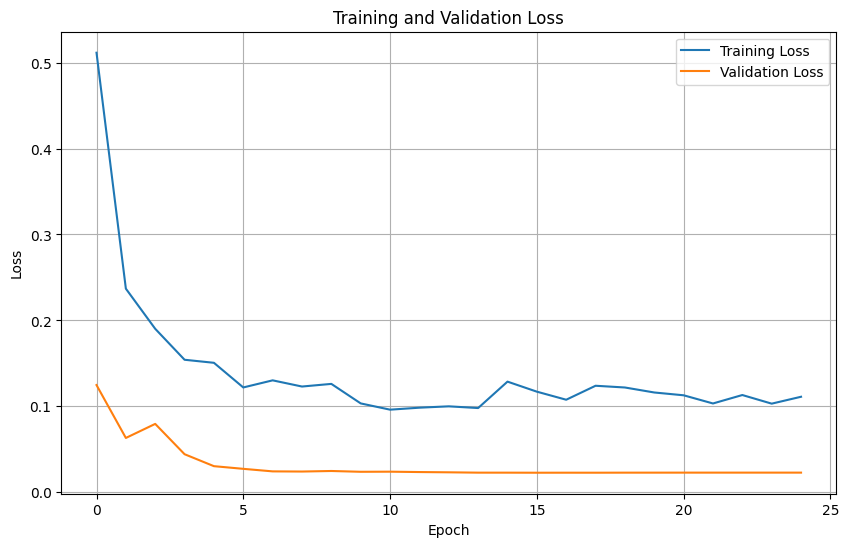

Fold:  4
Training:  263
Validation:  65
Epoch 0/24
----------
train Loss: 0.4844 Acc: 0.8023
val Loss: 0.1819 Acc: 0.9231

Epoch 1/24
----------
train Loss: 0.2228 Acc: 0.9202
val Loss: 0.1079 Acc: 0.9846

Epoch 2/24
----------
train Loss: 0.1529 Acc: 0.9544
val Loss: 0.0790 Acc: 0.9692

Epoch 3/24
----------
train Loss: 0.1656 Acc: 0.9430
val Loss: 0.0579 Acc: 0.9846

Epoch 4/24
----------
train Loss: 0.1396 Acc: 0.9468
val Loss: 0.0459 Acc: 1.0000

Epoch 5/24
----------
train Loss: 0.1106 Acc: 0.9696
val Loss: 0.0394 Acc: 1.0000

Epoch 6/24
----------
train Loss: 0.1230 Acc: 0.9620
val Loss: 0.0343 Acc: 1.0000

Epoch 7/24
----------
train Loss: 0.1379 Acc: 0.9468
val Loss: 0.0348 Acc: 1.0000

Epoch 8/24
----------
train Loss: 0.1045 Acc: 0.9734
val Loss: 0.0361 Acc: 0.9846

Epoch 9/24
----------
train Loss: 0.1214 Acc: 0.9468
val Loss: 0.0350 Acc: 1.0000

Epoch 10/24
----------
train Loss: 0.1278 Acc: 0.9582
val Loss: 0.0373 Acc: 0.9846

Epoch 11/24
----------
train Loss: 0.0863 Acc:

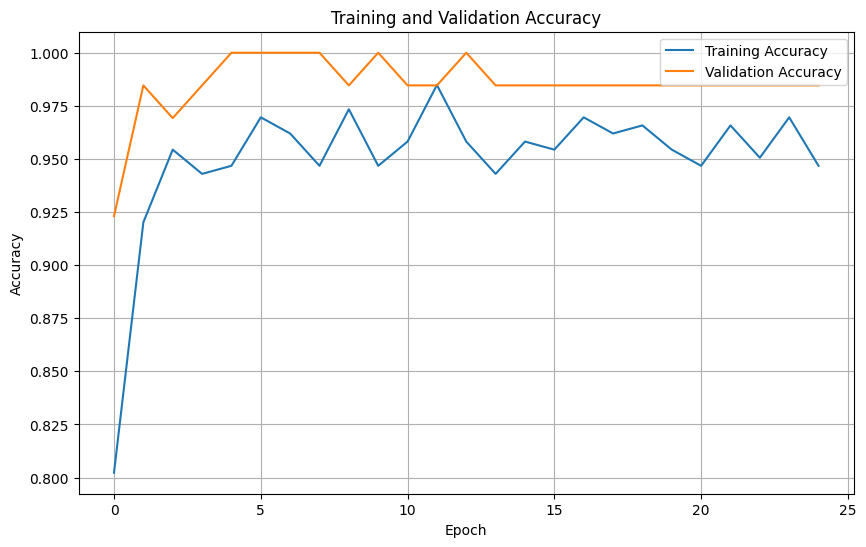

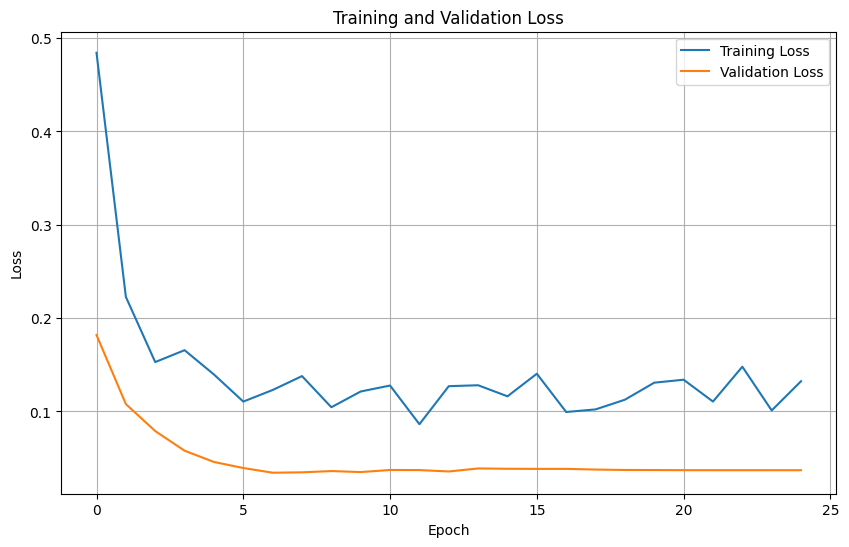

Average accuracy: 0.9640
Average precision: 0.9638
Average recall: 0.9635
Average F1 score: 0.9632
Average Time elapsed: 66.8584 seconds
Memory Usage: 844.8316 MiB


In [12]:
preTrainImageNet("alexnet",classes)

# Inception v3



```
Average accuracy: 0.8260
Average precision: 0.8331
Average recall: 0.8290
Average F1 score: 0.8278
Average Time elapsed: 121.1417 seconds
Memory Usage: 521.1688 MiB
```



Fold:  0
Training:  262
Validation:  66


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 151MB/s] 


Epoch 0/24
----------
train Loss: 1.1119 Acc: 0.3206
val Loss: 1.0315 Acc: 0.5303

Epoch 1/24
----------
train Loss: 1.0253 Acc: 0.4924
val Loss: 0.9279 Acc: 0.7424

Epoch 2/24
----------
train Loss: 0.9205 Acc: 0.6527
val Loss: 0.8695 Acc: 0.7121

Epoch 3/24
----------
train Loss: 0.8673 Acc: 0.6718
val Loss: 0.7992 Acc: 0.8485

Epoch 4/24
----------
train Loss: 0.8479 Acc: 0.7099
val Loss: 0.7519 Acc: 0.9394

Epoch 5/24
----------
train Loss: 0.7798 Acc: 0.7710
val Loss: 0.6990 Acc: 0.9394

Epoch 6/24
----------
train Loss: 0.7702 Acc: 0.7519
val Loss: 0.6674 Acc: 0.9697

Epoch 7/24
----------
train Loss: 0.7230 Acc: 0.8244
val Loss: 0.6470 Acc: 0.9697

Epoch 8/24
----------
train Loss: 0.7459 Acc: 0.8053
val Loss: 0.6448 Acc: 0.9848

Epoch 9/24
----------
train Loss: 0.7166 Acc: 0.8053
val Loss: 0.6605 Acc: 0.9697

Epoch 10/24
----------
train Loss: 0.6978 Acc: 0.8435
val Loss: 0.6493 Acc: 0.9848

Epoch 11/24
----------
train Loss: 0.7039 Acc: 0.8435
val Loss: 0.6452 Acc: 0.9545

Ep

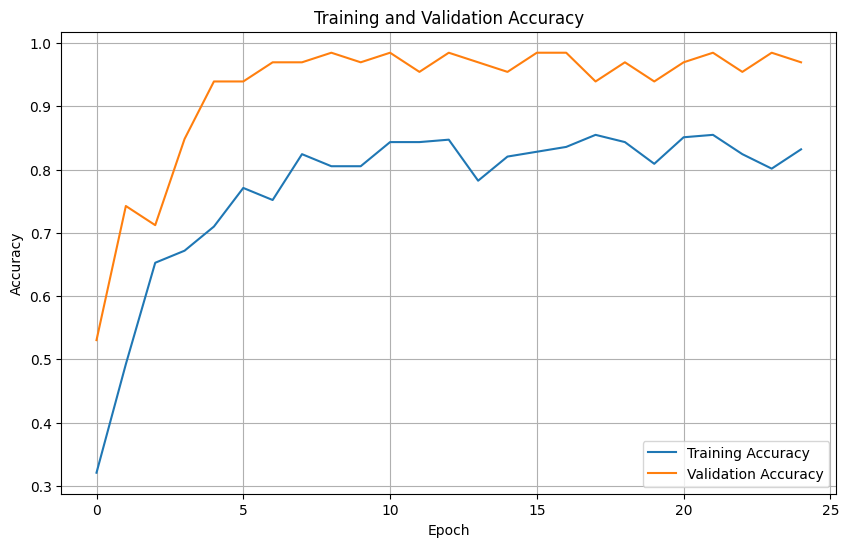

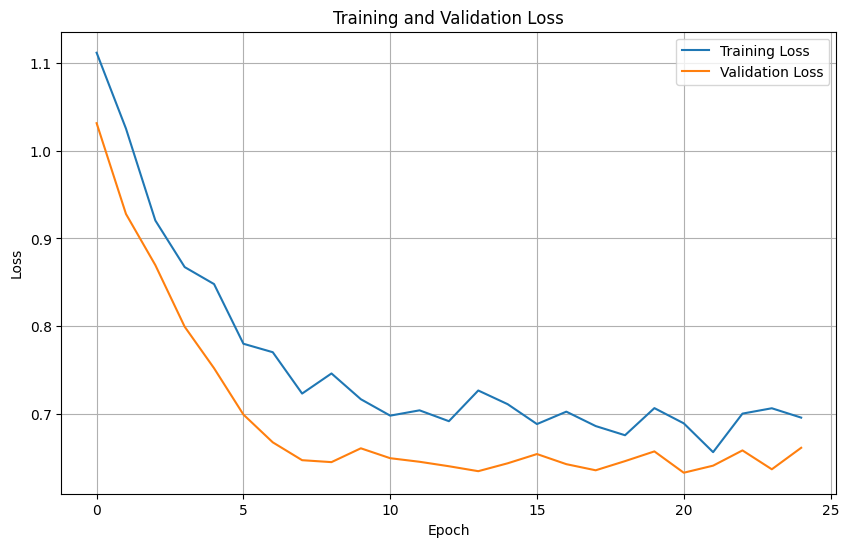

Fold:  1
Training:  262
Validation:  66
Epoch 0/24
----------
train Loss: 1.0999 Acc: 0.3817
val Loss: 0.9974 Acc: 0.5303

Epoch 1/24
----------
train Loss: 1.0137 Acc: 0.5115
val Loss: 0.9139 Acc: 0.8333

Epoch 2/24
----------
train Loss: 0.9370 Acc: 0.6260
val Loss: 0.8210 Acc: 0.8636

Epoch 3/24
----------
train Loss: 0.8646 Acc: 0.6947
val Loss: 0.7583 Acc: 0.9697

Epoch 4/24
----------
train Loss: 0.8152 Acc: 0.7634
val Loss: 0.6950 Acc: 0.9697

Epoch 5/24
----------
train Loss: 0.7774 Acc: 0.7366
val Loss: 0.6471 Acc: 0.9848

Epoch 6/24
----------
train Loss: 0.7547 Acc: 0.7595
val Loss: 0.6006 Acc: 0.9545

Epoch 7/24
----------
train Loss: 0.7212 Acc: 0.7901
val Loss: 0.6059 Acc: 0.9394

Epoch 8/24
----------
train Loss: 0.7136 Acc: 0.8130
val Loss: 0.6120 Acc: 0.9545

Epoch 9/24
----------
train Loss: 0.7101 Acc: 0.7939
val Loss: 0.5968 Acc: 0.9848

Epoch 10/24
----------
train Loss: 0.7059 Acc: 0.7977
val Loss: 0.6010 Acc: 0.9848

Epoch 11/24
----------
train Loss: 0.7088 Acc:

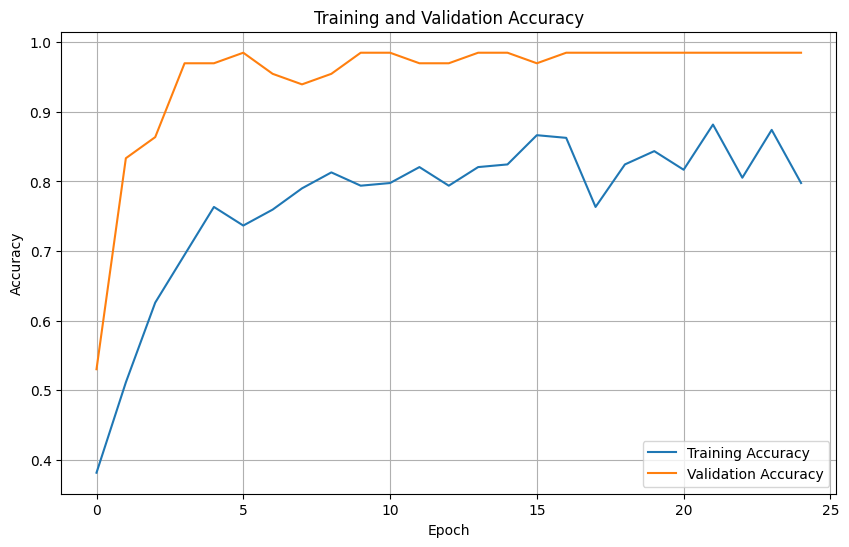

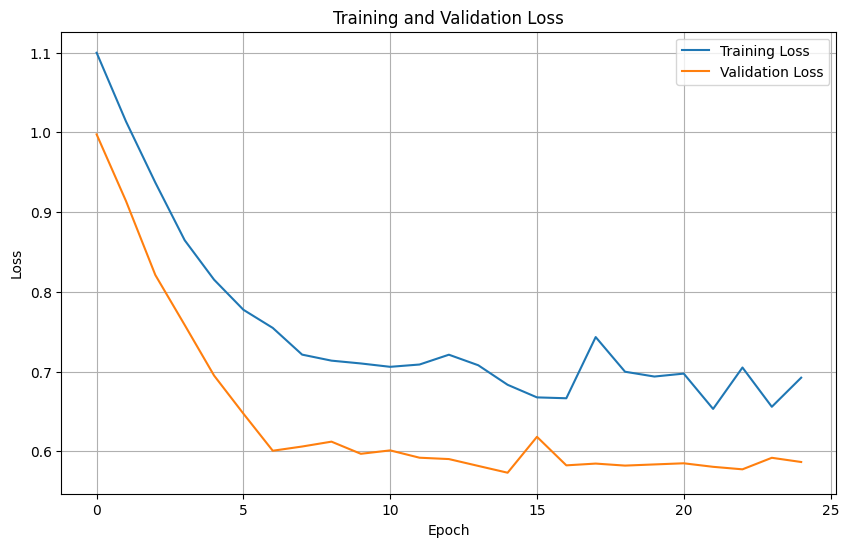

Fold:  2
Training:  262
Validation:  66
Epoch 0/24
----------
train Loss: 1.0933 Acc: 0.3626
val Loss: 1.0312 Acc: 0.4697

Epoch 1/24
----------
train Loss: 1.0237 Acc: 0.4885
val Loss: 0.9475 Acc: 0.6667

Epoch 2/24
----------
train Loss: 0.9417 Acc: 0.6221
val Loss: 0.8791 Acc: 0.8485

Epoch 3/24
----------
train Loss: 0.9063 Acc: 0.6679
val Loss: 0.8015 Acc: 0.9394

Epoch 4/24
----------
train Loss: 0.8315 Acc: 0.7023
val Loss: 0.7370 Acc: 0.9242

Epoch 5/24
----------
train Loss: 0.7886 Acc: 0.7595
val Loss: 0.7072 Acc: 0.9697

Epoch 6/24
----------
train Loss: 0.7603 Acc: 0.7748
val Loss: 0.6589 Acc: 0.9697

Epoch 7/24
----------
train Loss: 0.7649 Acc: 0.7595
val Loss: 0.6500 Acc: 0.9848

Epoch 8/24
----------
train Loss: 0.7645 Acc: 0.7710
val Loss: 0.6510 Acc: 0.9697

Epoch 9/24
----------
train Loss: 0.7065 Acc: 0.8321
val Loss: 0.6446 Acc: 0.9848

Epoch 10/24
----------
train Loss: 0.7357 Acc: 0.8435
val Loss: 0.6357 Acc: 0.9848

Epoch 11/24
----------
train Loss: 0.7189 Acc:

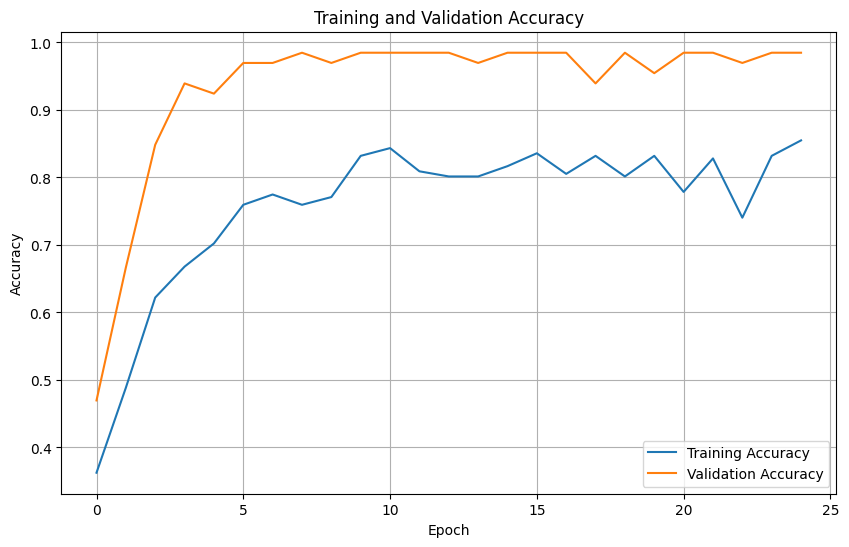

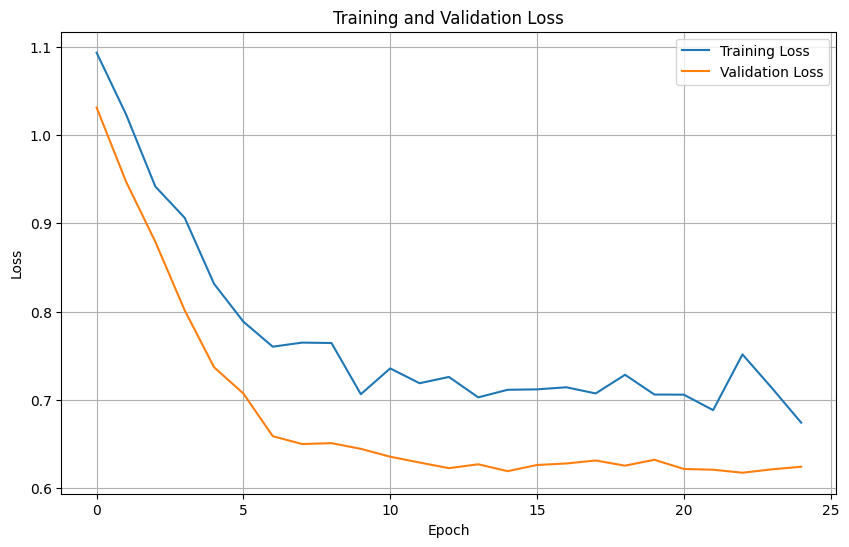

Fold:  3
Training:  263
Validation:  65
Epoch 0/24
----------
train Loss: 1.1042 Acc: 0.3536
val Loss: 0.9836 Acc: 0.5077

Epoch 1/24
----------
train Loss: 1.0331 Acc: 0.4639
val Loss: 0.9205 Acc: 0.8308

Epoch 2/24
----------
train Loss: 0.9089 Acc: 0.6540
val Loss: 0.8263 Acc: 0.9692

Epoch 3/24
----------
train Loss: 0.8674 Acc: 0.7148
val Loss: 0.7783 Acc: 0.9692

Epoch 4/24
----------
train Loss: 0.8411 Acc: 0.7338
val Loss: 0.7187 Acc: 0.9385

Epoch 5/24
----------
train Loss: 0.7692 Acc: 0.7757
val Loss: 0.6623 Acc: 1.0000

Epoch 6/24
----------
train Loss: 0.7318 Acc: 0.7795
val Loss: 0.6100 Acc: 1.0000

Epoch 7/24
----------
train Loss: 0.7144 Acc: 0.8213
val Loss: 0.6203 Acc: 0.9846

Epoch 8/24
----------
train Loss: 0.7149 Acc: 0.8175
val Loss: 0.6083 Acc: 1.0000

Epoch 9/24
----------
train Loss: 0.7427 Acc: 0.7490
val Loss: 0.6056 Acc: 1.0000

Epoch 10/24
----------
train Loss: 0.6973 Acc: 0.8327
val Loss: 0.6106 Acc: 1.0000

Epoch 11/24
----------
train Loss: 0.6906 Acc:

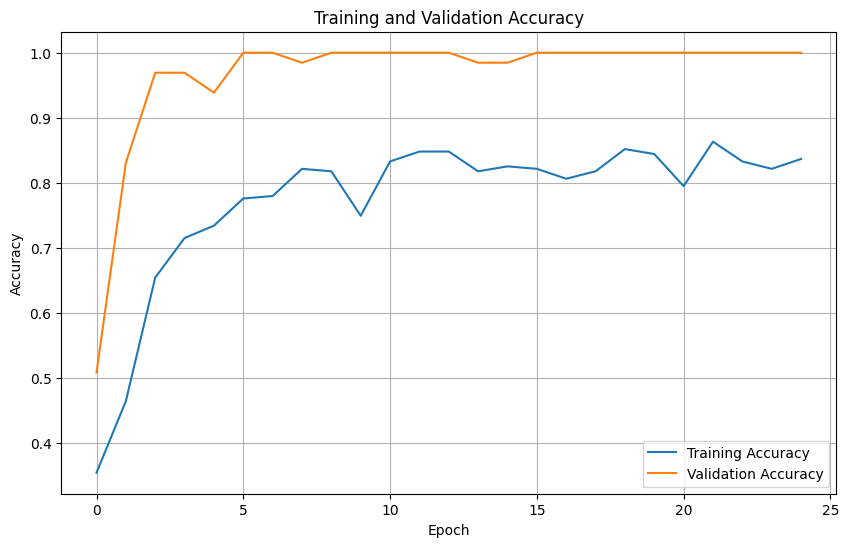

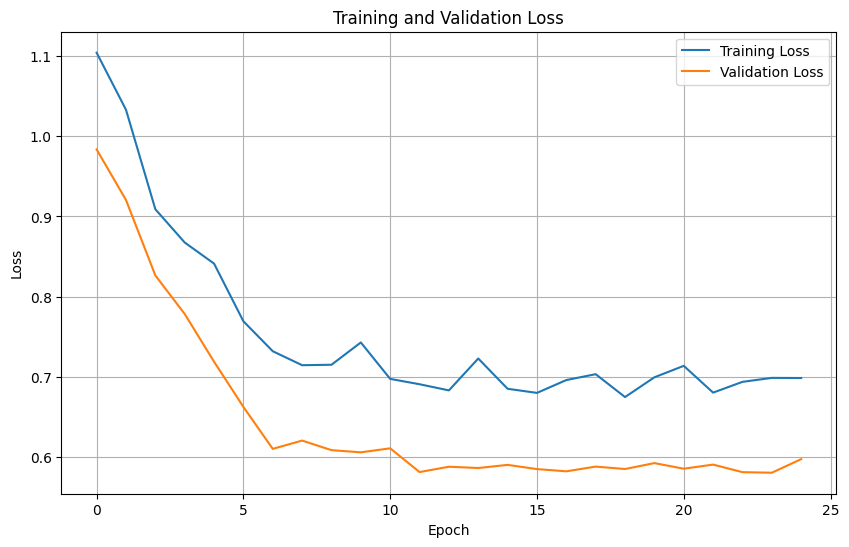

Fold:  4
Training:  263
Validation:  65
Epoch 0/24
----------
train Loss: 1.0797 Acc: 0.4106
val Loss: 1.0175 Acc: 0.5385

Epoch 1/24
----------
train Loss: 0.9956 Acc: 0.5513
val Loss: 0.9434 Acc: 0.6308

Epoch 2/24
----------
train Loss: 0.9209 Acc: 0.6350
val Loss: 0.8508 Acc: 0.8154

Epoch 3/24
----------
train Loss: 0.8521 Acc: 0.6844
val Loss: 0.7882 Acc: 0.9385

Epoch 4/24
----------
train Loss: 0.7910 Acc: 0.7757
val Loss: 0.7366 Acc: 0.9538

Epoch 5/24
----------
train Loss: 0.7443 Acc: 0.8175
val Loss: 0.6843 Acc: 0.9692

Epoch 6/24
----------
train Loss: 0.7235 Acc: 0.7947
val Loss: 0.6479 Acc: 0.9538

Epoch 7/24
----------
train Loss: 0.6779 Acc: 0.8023
val Loss: 0.6480 Acc: 0.9538

Epoch 8/24
----------
train Loss: 0.7276 Acc: 0.7452
val Loss: 0.6340 Acc: 0.9231

Epoch 9/24
----------
train Loss: 0.7009 Acc: 0.8061
val Loss: 0.6185 Acc: 0.9846

Epoch 10/24
----------
train Loss: 0.7187 Acc: 0.7871
val Loss: 0.6298 Acc: 0.9846

Epoch 11/24
----------
train Loss: 0.6859 Acc:

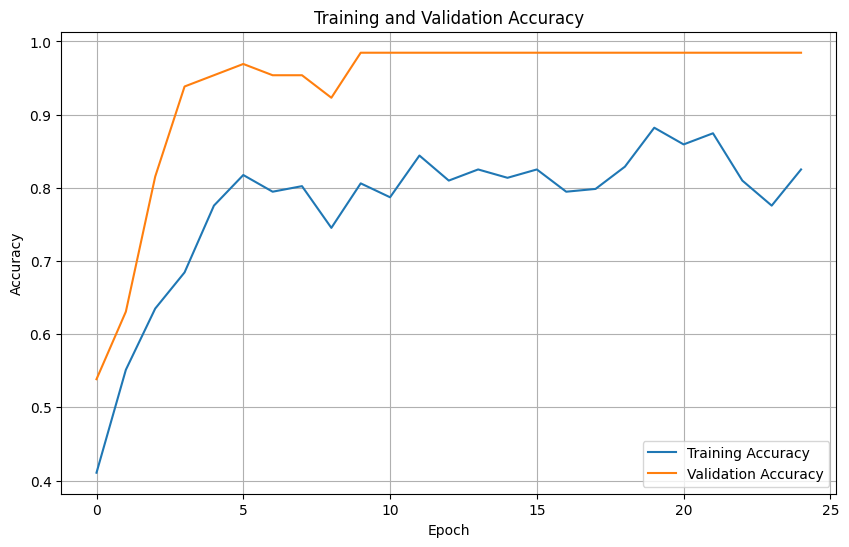

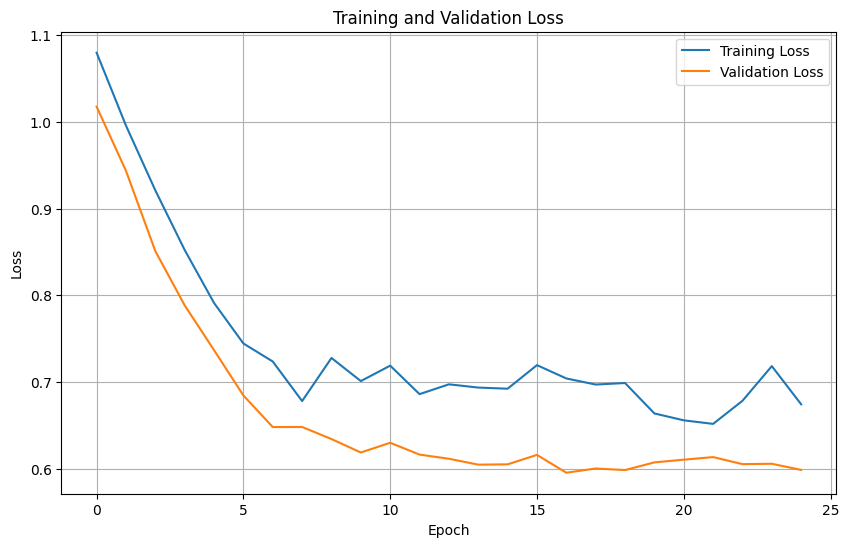

Average accuracy: 0.8260
Average precision: 0.8331
Average recall: 0.8290
Average F1 score: 0.8278
Average Time elapsed: 121.1417 seconds
Memory Usage: 521.1688 MiB


In [13]:
preTrainImageNet("inceptionv3",classes)

# VGG-16



```
Average accuracy: 0.9880
Average precision: 0.9878
Average recall: 0.9885
Average F1 score: 0.9881
Average Time elapsed: 117.5300 seconds
Memory Usage: 1967.6973 MiB
```



Fold:  0
Training:  262
Validation:  66


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:06<00:00, 82.4MB/s]


Epoch 0/24
----------
train Loss: 0.6226 Acc: 0.8015
val Loss: 0.3662 Acc: 0.9242

Epoch 1/24
----------
train Loss: 0.3005 Acc: 0.9313
val Loss: 0.2406 Acc: 0.9848

Epoch 2/24
----------
train Loss: 0.2117 Acc: 0.9618
val Loss: 0.1907 Acc: 0.9697

Epoch 3/24
----------
train Loss: 0.1624 Acc: 0.9847
val Loss: 0.1579 Acc: 1.0000

Epoch 4/24
----------
train Loss: 0.1418 Acc: 0.9809
val Loss: 0.1375 Acc: 1.0000

Epoch 5/24
----------
train Loss: 0.1109 Acc: 0.9885
val Loss: 0.1236 Acc: 1.0000

Epoch 6/24
----------
train Loss: 0.1049 Acc: 0.9885
val Loss: 0.1152 Acc: 1.0000

Epoch 7/24
----------
train Loss: 0.1150 Acc: 0.9847
val Loss: 0.1135 Acc: 1.0000

Epoch 8/24
----------
train Loss: 0.1138 Acc: 0.9809
val Loss: 0.1121 Acc: 1.0000

Epoch 9/24
----------
train Loss: 0.0931 Acc: 0.9924
val Loss: 0.1114 Acc: 1.0000

Epoch 10/24
----------
train Loss: 0.0975 Acc: 0.9924
val Loss: 0.1104 Acc: 1.0000

Epoch 11/24
----------
train Loss: 0.0865 Acc: 0.9962
val Loss: 0.1094 Acc: 1.0000

Ep

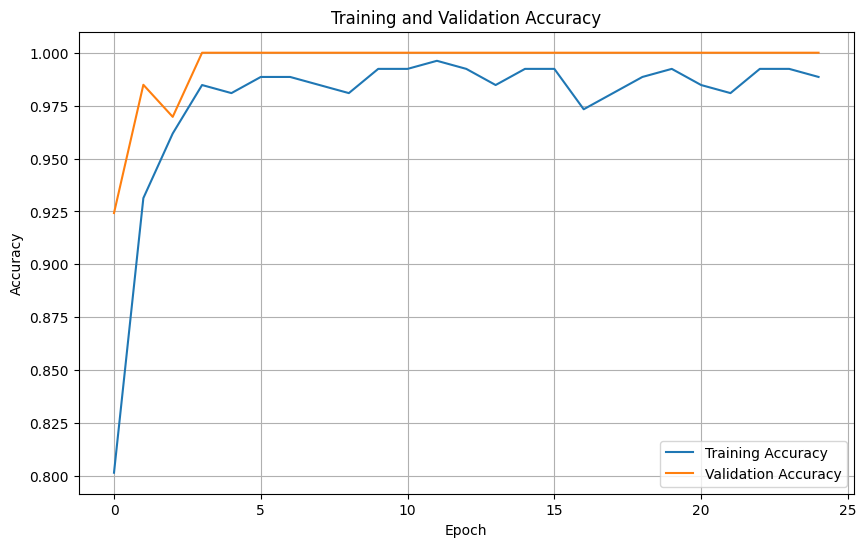

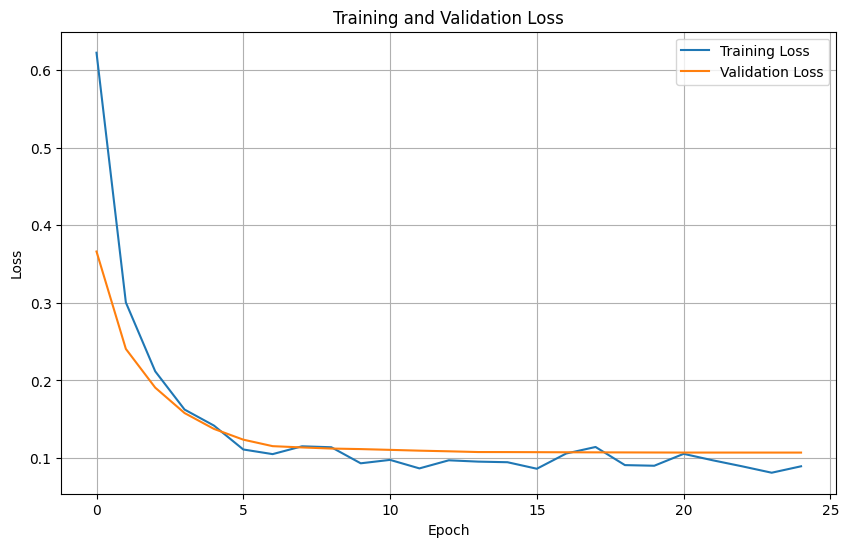

Fold:  1
Training:  262
Validation:  66
Epoch 0/24
----------
train Loss: 0.6516 Acc: 0.7595
val Loss: 0.3393 Acc: 0.9394

Epoch 1/24
----------
train Loss: 0.2893 Acc: 0.9389
val Loss: 0.2130 Acc: 0.9848

Epoch 2/24
----------
train Loss: 0.2085 Acc: 0.9656
val Loss: 0.1525 Acc: 1.0000

Epoch 3/24
----------
train Loss: 0.1830 Acc: 0.9695
val Loss: 0.1332 Acc: 1.0000

Epoch 4/24
----------
train Loss: 0.1470 Acc: 0.9885
val Loss: 0.1036 Acc: 1.0000

Epoch 5/24
----------
train Loss: 0.1248 Acc: 0.9847
val Loss: 0.0977 Acc: 1.0000

Epoch 6/24
----------
train Loss: 0.1156 Acc: 0.9924
val Loss: 0.0808 Acc: 1.0000

Epoch 7/24
----------
train Loss: 0.1062 Acc: 0.9847
val Loss: 0.0793 Acc: 1.0000

Epoch 8/24
----------
train Loss: 0.1006 Acc: 0.9885
val Loss: 0.0786 Acc: 1.0000

Epoch 9/24
----------
train Loss: 0.1121 Acc: 0.9847
val Loss: 0.0781 Acc: 1.0000

Epoch 10/24
----------
train Loss: 0.1059 Acc: 0.9847
val Loss: 0.0773 Acc: 1.0000

Epoch 11/24
----------
train Loss: 0.1071 Acc:

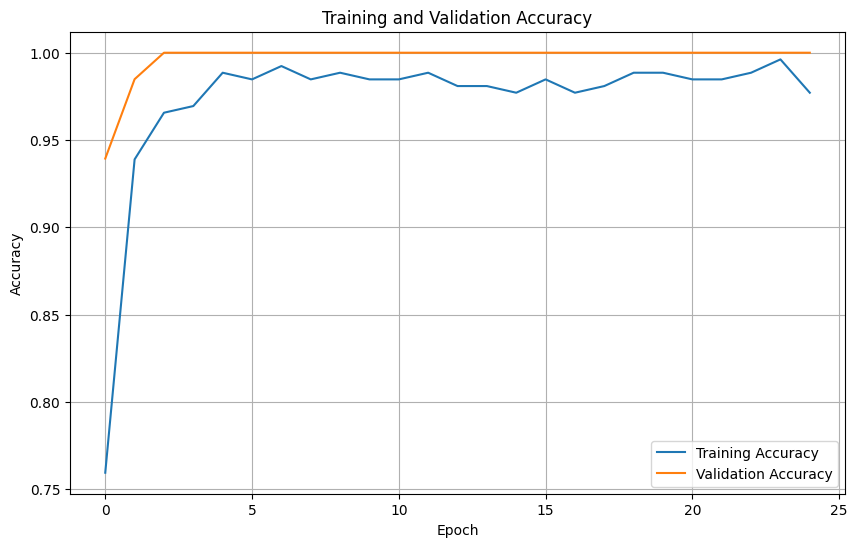

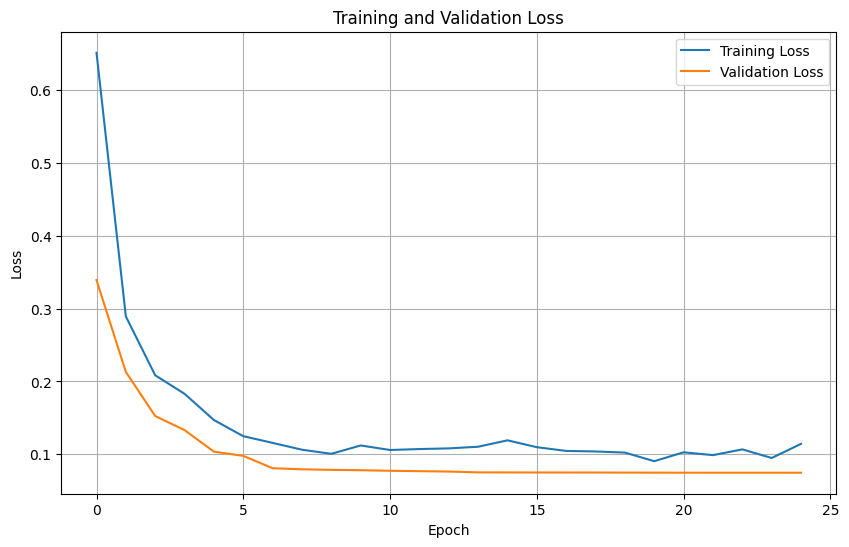

Fold:  2
Training:  262
Validation:  66
Epoch 0/24
----------
train Loss: 0.6752 Acc: 0.7176
val Loss: 0.3923 Acc: 0.9091

Epoch 1/24
----------
train Loss: 0.3306 Acc: 0.9160
val Loss: 0.2141 Acc: 0.9697

Epoch 2/24
----------
train Loss: 0.2313 Acc: 0.9733
val Loss: 0.1634 Acc: 0.9848

Epoch 3/24
----------
train Loss: 0.1688 Acc: 0.9771
val Loss: 0.1196 Acc: 0.9848

Epoch 4/24
----------
train Loss: 0.1501 Acc: 0.9695
val Loss: 0.1005 Acc: 1.0000

Epoch 5/24
----------
train Loss: 0.1226 Acc: 0.9847
val Loss: 0.0869 Acc: 1.0000

Epoch 6/24
----------
train Loss: 0.1120 Acc: 0.9924
val Loss: 0.0845 Acc: 0.9848

Epoch 7/24
----------
train Loss: 0.1031 Acc: 0.9885
val Loss: 0.0795 Acc: 1.0000

Epoch 8/24
----------
train Loss: 0.1138 Acc: 0.9847
val Loss: 0.0773 Acc: 1.0000

Epoch 9/24
----------
train Loss: 0.1074 Acc: 0.9847
val Loss: 0.0754 Acc: 1.0000

Epoch 10/24
----------
train Loss: 0.0936 Acc: 0.9962
val Loss: 0.0744 Acc: 1.0000

Epoch 11/24
----------
train Loss: 0.0936 Acc:

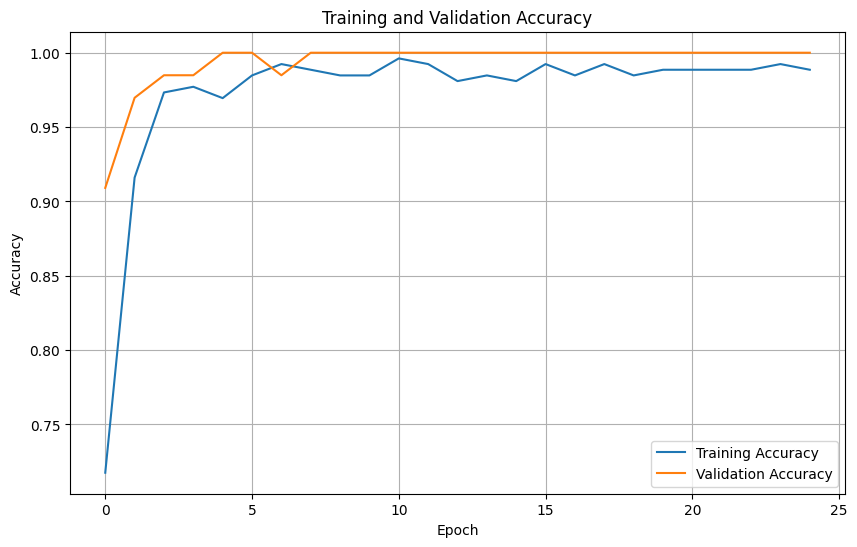

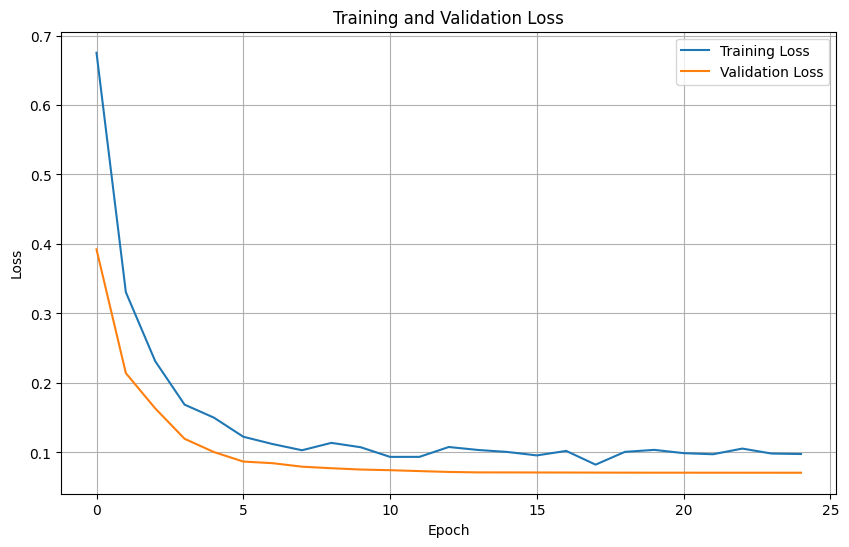

Fold:  3
Training:  263
Validation:  65
Epoch 0/24
----------
train Loss: 0.6133 Acc: 0.7833
val Loss: 0.3273 Acc: 0.9846

Epoch 1/24
----------
train Loss: 0.2849 Acc: 0.9544
val Loss: 0.2252 Acc: 1.0000

Epoch 2/24
----------
train Loss: 0.1898 Acc: 0.9848
val Loss: 0.1715 Acc: 1.0000

Epoch 3/24
----------
train Loss: 0.1519 Acc: 0.9772
val Loss: 0.1426 Acc: 1.0000

Epoch 4/24
----------
train Loss: 0.1450 Acc: 0.9924
val Loss: 0.1232 Acc: 1.0000

Epoch 5/24
----------
train Loss: 0.1224 Acc: 0.9924
val Loss: 0.1087 Acc: 1.0000

Epoch 6/24
----------
train Loss: 0.1158 Acc: 0.9810
val Loss: 0.1014 Acc: 1.0000

Epoch 7/24
----------
train Loss: 0.1013 Acc: 0.9886
val Loss: 0.0990 Acc: 1.0000

Epoch 8/24
----------
train Loss: 0.0930 Acc: 0.9924
val Loss: 0.0975 Acc: 1.0000

Epoch 9/24
----------
train Loss: 0.0899 Acc: 0.9962
val Loss: 0.0961 Acc: 1.0000

Epoch 10/24
----------
train Loss: 0.0944 Acc: 0.9848
val Loss: 0.0953 Acc: 1.0000

Epoch 11/24
----------
train Loss: 0.0921 Acc:

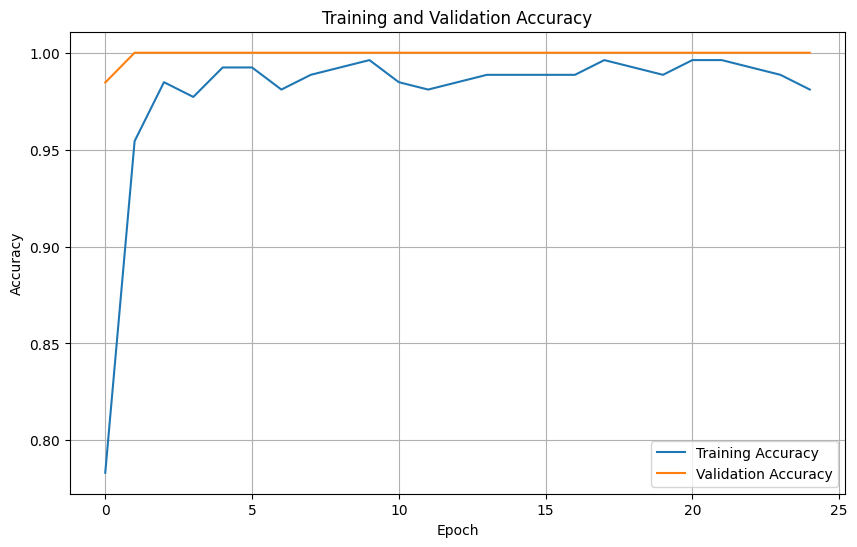

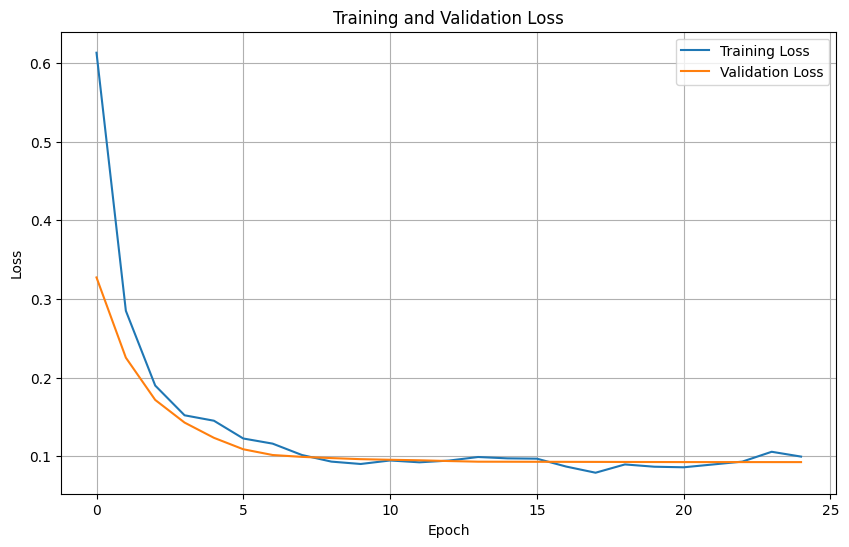

Fold:  4
Training:  263
Validation:  65
Epoch 0/24
----------
train Loss: 0.6151 Acc: 0.7795
val Loss: 0.3388 Acc: 0.9692

Epoch 1/24
----------
train Loss: 0.2999 Acc: 0.9278
val Loss: 0.2254 Acc: 0.9692

Epoch 2/24
----------
train Loss: 0.2143 Acc: 0.9658
val Loss: 0.1809 Acc: 0.9692

Epoch 3/24
----------
train Loss: 0.1653 Acc: 0.9734
val Loss: 0.1530 Acc: 0.9846

Epoch 4/24
----------
train Loss: 0.1482 Acc: 0.9848
val Loss: 0.1403 Acc: 0.9692

Epoch 5/24
----------
train Loss: 0.1136 Acc: 0.9924
val Loss: 0.1222 Acc: 0.9846

Epoch 6/24
----------
train Loss: 0.1063 Acc: 0.9810
val Loss: 0.1129 Acc: 0.9846

Epoch 7/24
----------
train Loss: 0.1014 Acc: 0.9924
val Loss: 0.1121 Acc: 0.9846

Epoch 8/24
----------
train Loss: 0.0945 Acc: 0.9962
val Loss: 0.1114 Acc: 0.9846

Epoch 9/24
----------
train Loss: 0.1029 Acc: 0.9924
val Loss: 0.1106 Acc: 0.9846

Epoch 10/24
----------
train Loss: 0.0938 Acc: 0.9848
val Loss: 0.1098 Acc: 0.9846

Epoch 11/24
----------
train Loss: 0.0913 Acc:

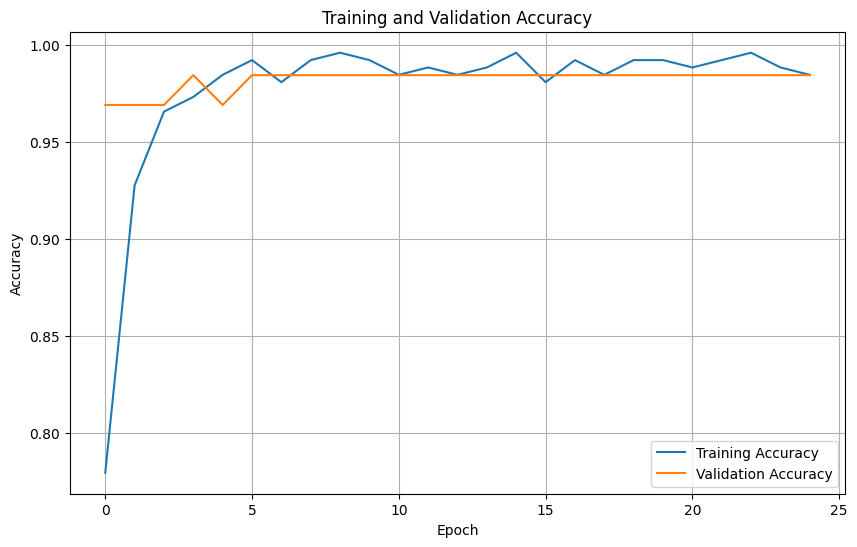

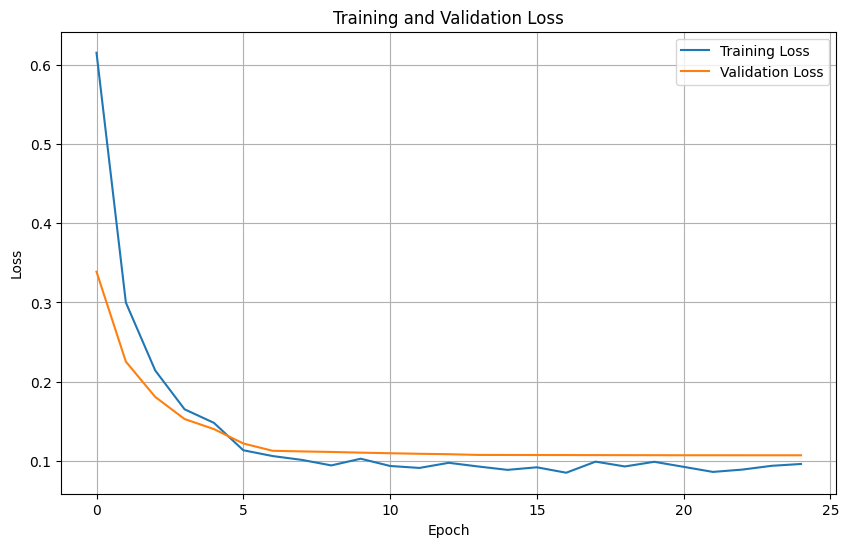

Average accuracy: 0.9880
Average precision: 0.9878
Average recall: 0.9885
Average F1 score: 0.9881
Average Time elapsed: 117.5300 seconds
Memory Usage: 1967.6973 MiB


In [14]:
preTrainImageNet("vgg16", classes)

# ResNet-18



```
Average accuracy: 0.8060
Average precision: 0.8120
Average recall: 0.8076
Average F1 score: 0.8067
Average Time elapsed: 77.9112 seconds
Memory Usage: 181.5029 MiB
```



Fold:  0
Training:  262
Validation:  66


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 0/24
----------
train Loss: 1.0453 Acc: 0.4198
val Loss: 0.9410 Acc: 0.5606

Epoch 1/24
----------
train Loss: 0.8839 Acc: 0.6298
val Loss: 0.7068 Acc: 0.7727

Epoch 2/24
----------
train Loss: 0.8088 Acc: 0.6756
val Loss: 0.6368 Acc: 0.7576

Epoch 3/24
----------
train Loss: 0.7186 Acc: 0.6947
val Loss: 0.4801 Acc: 0.8788

Epoch 4/24
----------
train Loss: 0.6663 Acc: 0.7481
val Loss: 0.4852 Acc: 0.7879

Epoch 5/24
----------
train Loss: 0.5612 Acc: 0.8511
val Loss: 0.3982 Acc: 0.8788

Epoch 6/24
----------
train Loss: 0.5961 Acc: 0.7939
val Loss: 0.3474 Acc: 0.8939

Epoch 7/24
----------
train Loss: 0.5868 Acc: 0.8015
val Loss: 0.3286 Acc: 0.9091

Epoch 8/24
----------
train Loss: 0.5295 Acc: 0.8664
val Loss: 0.3605 Acc: 0.9091

Epoch 9/24
----------
train Loss: 0.5517 Acc: 0.8244
val Loss: 0.3259 Acc: 0.9394

Epoch 10/24
----------
train Loss: 0.4749 Acc: 0.8855
val Loss: 0.3429 Acc: 0.9394

Epoch 11/24
----------
train Loss: 0.6023 Acc: 0.7786
val Loss: 0.3027 Acc: 0.9394

Ep

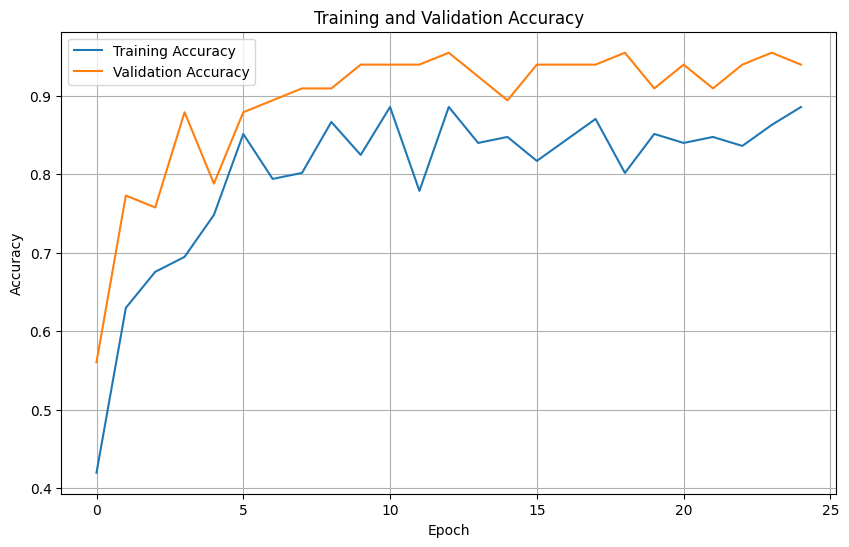

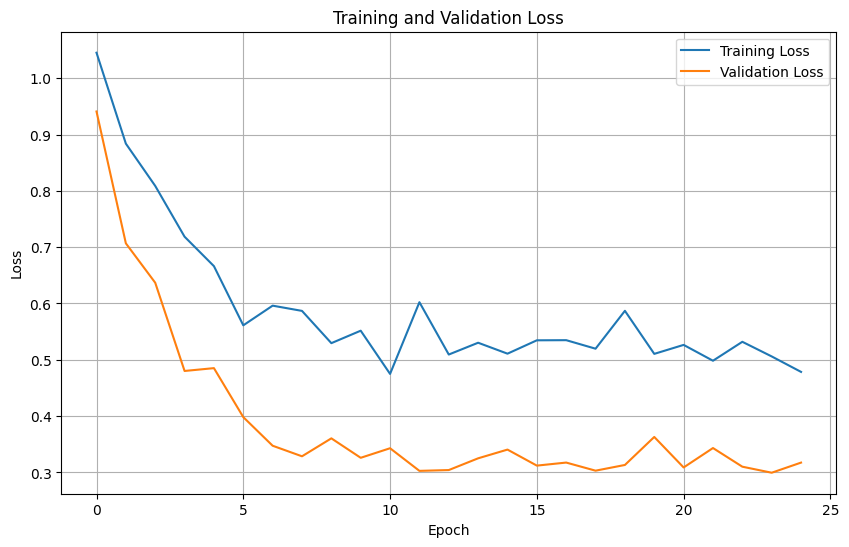

Fold:  1
Training:  262
Validation:  66
Epoch 0/24
----------
train Loss: 1.0440 Acc: 0.4733
val Loss: 0.8588 Acc: 0.6667

Epoch 1/24
----------
train Loss: 0.8856 Acc: 0.6221
val Loss: 0.6643 Acc: 0.7273

Epoch 2/24
----------
train Loss: 0.7820 Acc: 0.7290
val Loss: 0.5334 Acc: 0.8939

Epoch 3/24
----------
train Loss: 0.6900 Acc: 0.7824
val Loss: 0.4617 Acc: 0.9394

Epoch 4/24
----------
train Loss: 0.6564 Acc: 0.7863
val Loss: 0.3913 Acc: 0.9091

Epoch 5/24
----------
train Loss: 0.5604 Acc: 0.8359
val Loss: 0.3288 Acc: 0.9394

Epoch 6/24
----------
train Loss: 0.5474 Acc: 0.8435
val Loss: 0.3017 Acc: 0.9394

Epoch 7/24
----------
train Loss: 0.5085 Acc: 0.8282
val Loss: 0.2853 Acc: 0.9697

Epoch 8/24
----------
train Loss: 0.5831 Acc: 0.7977
val Loss: 0.2911 Acc: 0.9242

Epoch 9/24
----------
train Loss: 0.5580 Acc: 0.8244
val Loss: 0.3023 Acc: 0.9545

Epoch 10/24
----------
train Loss: 0.5650 Acc: 0.8359
val Loss: 0.3053 Acc: 0.9394

Epoch 11/24
----------
train Loss: 0.5062 Acc:

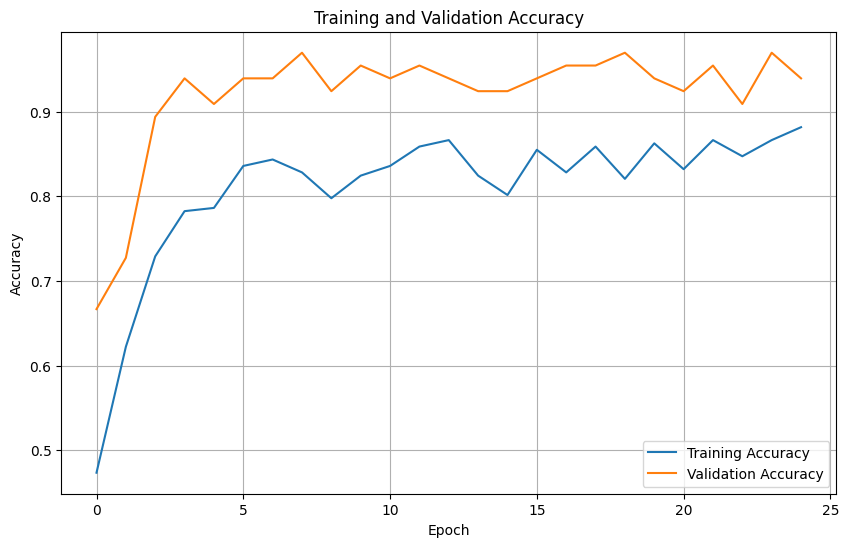

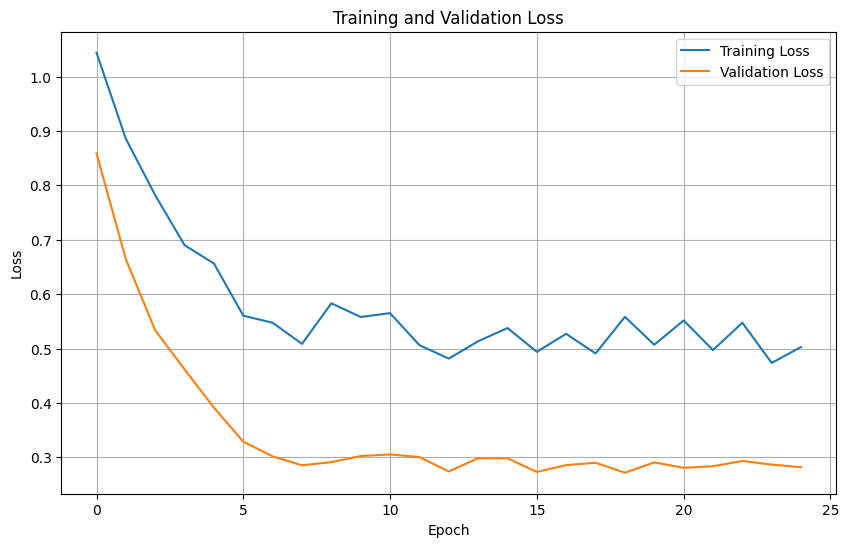

Fold:  2
Training:  262
Validation:  66
Epoch 0/24
----------
train Loss: 1.0555 Acc: 0.4542
val Loss: 0.8676 Acc: 0.6364

Epoch 1/24
----------
train Loss: 0.8567 Acc: 0.6374
val Loss: 0.6204 Acc: 0.8788

Epoch 2/24
----------
train Loss: 0.7806 Acc: 0.7405
val Loss: 0.4989 Acc: 0.9242

Epoch 3/24
----------
train Loss: 0.6792 Acc: 0.7557
val Loss: 0.4328 Acc: 0.9242

Epoch 4/24
----------
train Loss: 0.6411 Acc: 0.8168
val Loss: 0.3719 Acc: 0.9545

Epoch 5/24
----------
train Loss: 0.6477 Acc: 0.7557
val Loss: 0.3334 Acc: 0.9394

Epoch 6/24
----------
train Loss: 0.5849 Acc: 0.7939
val Loss: 0.2579 Acc: 1.0000

Epoch 7/24
----------
train Loss: 0.5023 Acc: 0.8511
val Loss: 0.2838 Acc: 0.9848

Epoch 8/24
----------
train Loss: 0.5998 Acc: 0.7901
val Loss: 0.2818 Acc: 0.9848

Epoch 9/24
----------
train Loss: 0.5555 Acc: 0.8321
val Loss: 0.2752 Acc: 0.9848

Epoch 10/24
----------
train Loss: 0.5053 Acc: 0.8473
val Loss: 0.2605 Acc: 1.0000

Epoch 11/24
----------
train Loss: 0.5529 Acc:

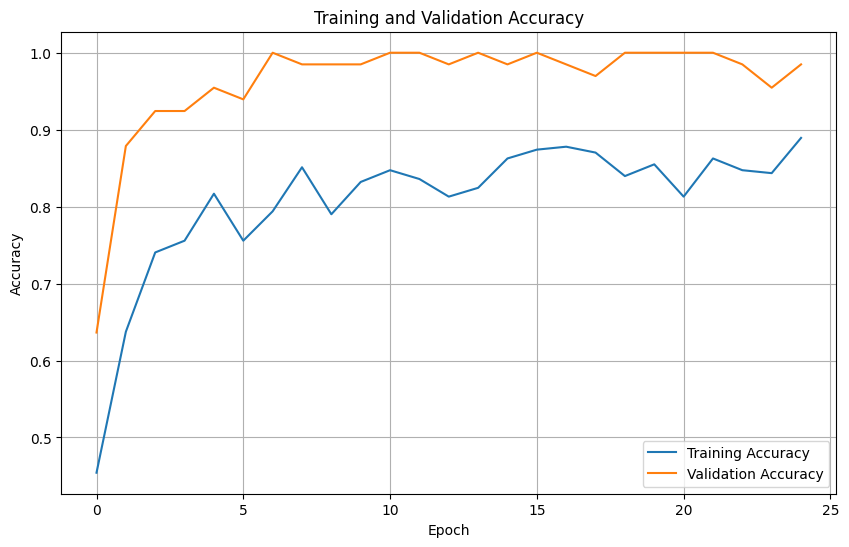

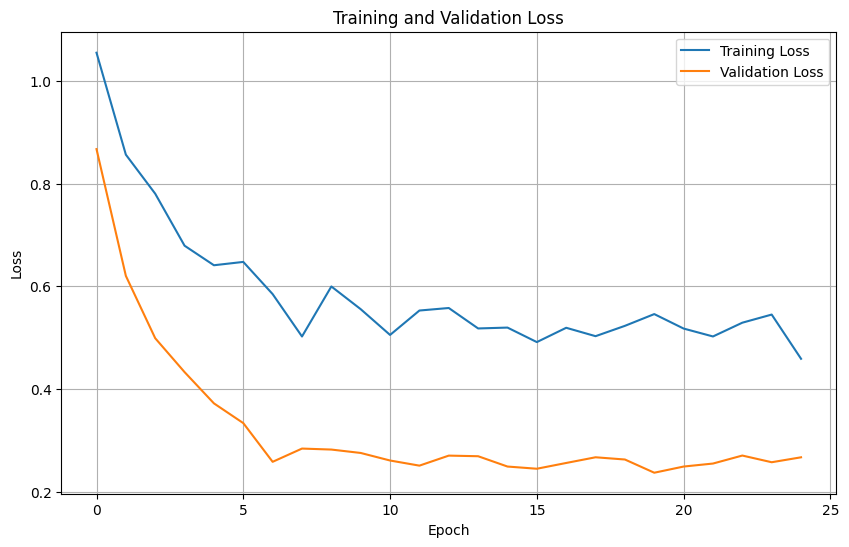

Fold:  3
Training:  263
Validation:  65
Epoch 0/24
----------
train Loss: 1.0678 Acc: 0.4525
val Loss: 0.9541 Acc: 0.5846

Epoch 1/24
----------
train Loss: 0.9080 Acc: 0.6046
val Loss: 0.7641 Acc: 0.7385

Epoch 2/24
----------
train Loss: 0.8055 Acc: 0.7034
val Loss: 0.6489 Acc: 0.7692

Epoch 3/24
----------
train Loss: 0.7393 Acc: 0.7186
val Loss: 0.5436 Acc: 0.8462

Epoch 4/24
----------
train Loss: 0.6892 Acc: 0.7300
val Loss: 0.4548 Acc: 0.8923

Epoch 5/24
----------
train Loss: 0.6316 Acc: 0.7909
val Loss: 0.3799 Acc: 0.9538

Epoch 6/24
----------
train Loss: 0.5991 Acc: 0.7985
val Loss: 0.3436 Acc: 0.9538

Epoch 7/24
----------
train Loss: 0.5646 Acc: 0.8175
val Loss: 0.3345 Acc: 0.9692

Epoch 8/24
----------
train Loss: 0.5730 Acc: 0.8137
val Loss: 0.3369 Acc: 0.9231

Epoch 9/24
----------
train Loss: 0.5530 Acc: 0.8403
val Loss: 0.3302 Acc: 0.9692

Epoch 10/24
----------
train Loss: 0.5187 Acc: 0.8593
val Loss: 0.3282 Acc: 0.9692

Epoch 11/24
----------
train Loss: 0.5242 Acc:

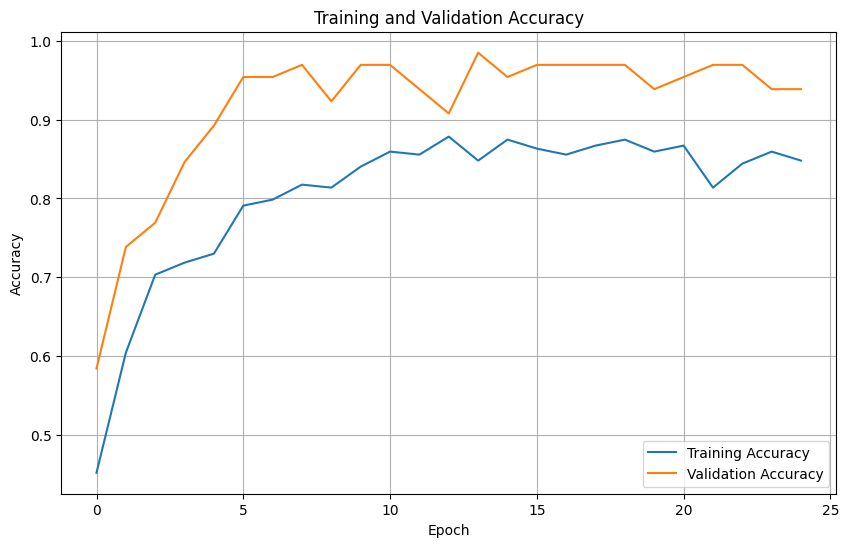

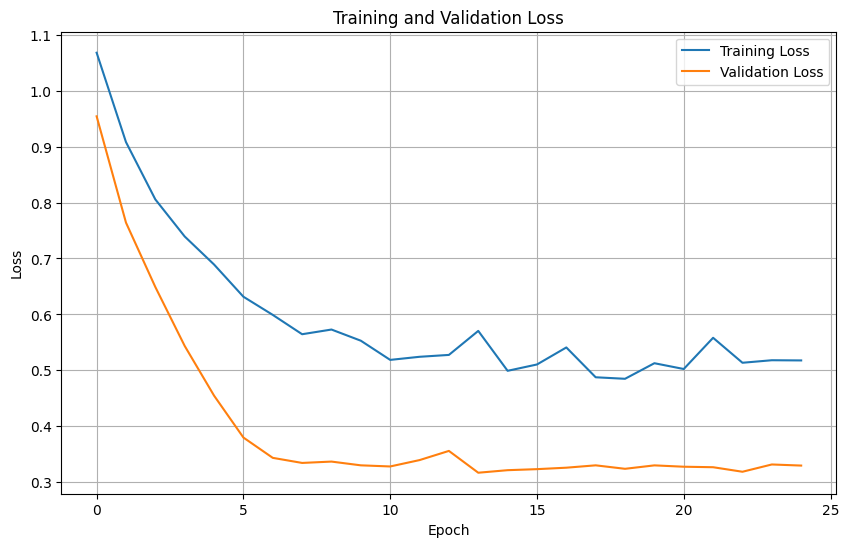

Fold:  4
Training:  263
Validation:  65
Epoch 0/24
----------
train Loss: 1.0265 Acc: 0.4715
val Loss: 0.8628 Acc: 0.5846

Epoch 1/24
----------
train Loss: 0.8618 Acc: 0.6540
val Loss: 0.6782 Acc: 0.8615

Epoch 2/24
----------
train Loss: 0.8098 Acc: 0.6882
val Loss: 0.5442 Acc: 0.9077

Epoch 3/24
----------
train Loss: 0.7100 Acc: 0.7452
val Loss: 0.4728 Acc: 0.8308

Epoch 4/24
----------
train Loss: 0.6453 Acc: 0.7833
val Loss: 0.3926 Acc: 0.9077

Epoch 5/24
----------
train Loss: 0.6343 Acc: 0.7719
val Loss: 0.3475 Acc: 0.9692

Epoch 6/24
----------
train Loss: 0.5905 Acc: 0.8023
val Loss: 0.2980 Acc: 0.9846

Epoch 7/24
----------
train Loss: 0.5416 Acc: 0.8061
val Loss: 0.3134 Acc: 0.9846

Epoch 8/24
----------
train Loss: 0.5702 Acc: 0.7985
val Loss: 0.2826 Acc: 0.9846

Epoch 9/24
----------
train Loss: 0.5515 Acc: 0.8327
val Loss: 0.2990 Acc: 1.0000

Epoch 10/24
----------
train Loss: 0.5311 Acc: 0.8593
val Loss: 0.2893 Acc: 0.9846

Epoch 11/24
----------
train Loss: 0.5714 Acc:

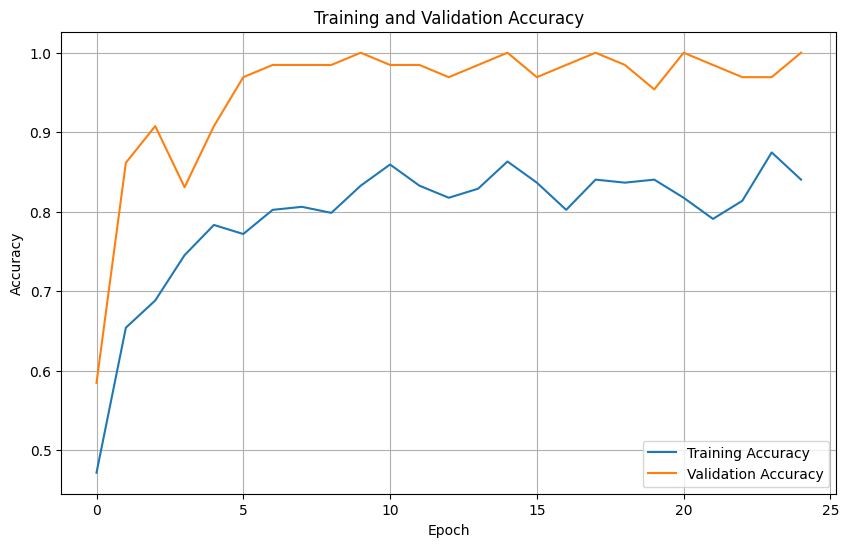

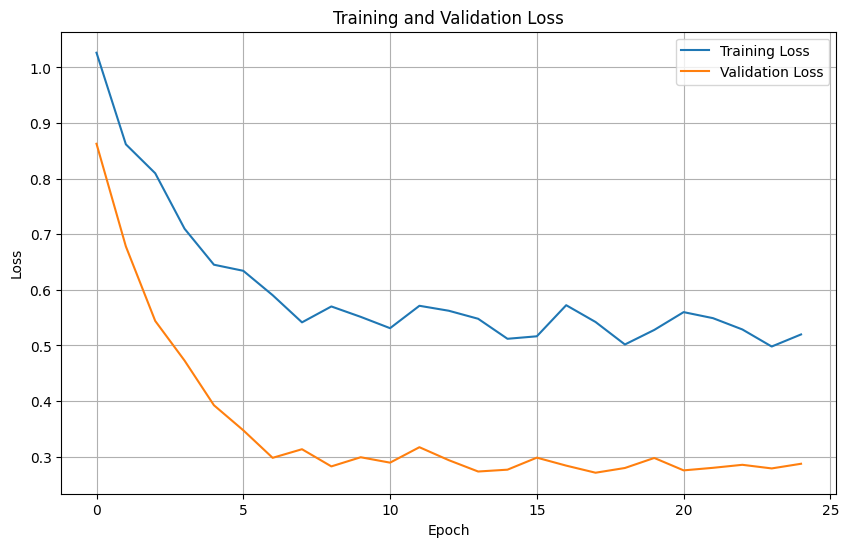

Average accuracy: 0.8060
Average precision: 0.8120
Average recall: 0.8076
Average F1 score: 0.8067
Average Time elapsed: 77.9112 seconds
Memory Usage: 181.5029 MiB


In [16]:
preTrainImageNet("resnet18", classes)